# EDA
> Looking at our files and plotting anglez, enmo, events and non-events for the first 21 people

In [1]:
#| default_exp eda

In [2]:
#| hide 
%config Completer.use_jedi = False # for faster tab completion

In [3]:
#| export 
from fastcore.all import Path
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#| export
IN = Path('../input')
SMALL_RAW = Path('../input_small/child-mind-institute-detect-sleep-states')
SMALL_RAW.mkdir(exist_ok=True, parents=True)
steps_in_day = 12 * 60 * 24 # based on steps being 5 seconds
first_n_rows = 10_000_000

In [5]:
RAW = SMALL_RAW # For CI testing with small data

In [6]:
#| export
#| notest
RAW = IN/'child-mind-institute-detect-sleep-states' 

In [7]:
# print(f'There are {steps_in_day} steps in a day')
# print(f'We will consider data from the first {first_n_rows:,} rows in the train series data')

## Input files
 `train_events.csv`

In [8]:
[x.stem + x.suffix for x in RAW.ls()]

['sample_submission.csv',
 'test_series.parquet',
 'train_events.csv',
 'train_series.parquet']

In [10]:
%%time
ss = pd.read_csv(RAW/'sample_submission.csv')
train_events = pd.read_csv(RAW/'train_events.csv')
train_series = pd.read_parquet(RAW/'train_series.parquet')
test_series = pd.read_parquet(RAW/'test_series.parquet')

CPU times: user 48.4 s, sys: 20.2 s, total: 1min 8s
Wall time: 27.1 s


In [11]:
assert test_series.columns.equals(train_series.columns)

### Saving small data for CI testing in github

In [12]:
small_train = train_series[train_series.series_id == '038441c925bb']
ss.to_csv(SMALL_RAW/'sample_submission.csv')
train_events.to_csv(SMALL_RAW/'train_events.csv')
small_train.to_parquet(SMALL_RAW/'train_series.parquet')
test_series.to_parquet(SMALL_RAW/'test_series.parquet')

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


## Test input
Here, `test_series` is to show the format. The true test set is only availaible during contest submission.

In [13]:
test_series

series_id  step                 timestamp     anglez    enmo
0    038441c925bb     0  2018-08-14T15:30:00-0400   2.636700  0.0217
1    038441c925bb     1  2018-08-14T15:30:05-0400   2.636800  0.0215
2    038441c925bb     2  2018-08-14T15:30:10-0400   2.637000  0.0216
3    038441c925bb     3  2018-08-14T15:30:15-0400   2.636800  0.0213
4    038441c925bb     4  2018-08-14T15:30:20-0400   2.636800  0.0215
..            ...   ...                       ...        ...     ...
445  0402a003dae9   145  2018-12-18T12:57:05-0500 -59.696899  0.0601
446  0402a003dae9   146  2018-12-18T12:57:10-0500 -35.656601  0.0427
447  0402a003dae9   147  2018-12-18T12:57:15-0500 -21.582399  0.0309
448  0402a003dae9   148  2018-12-18T12:57:20-0500 -42.616001  0.0328
449  0402a003dae9   149  2018-12-18T12:57:25-0500   7.029900  0.0081

[450 rows x 5 columns]

### Sample submission
For each series we submit predicted `onset` and `wakeup` events along with a confidence score between 0 and 1. We can submit as many predictions as we want, which will make more sense in accordance to the average precision scoring metric. 

In [14]:
ss

row_id     series_id  step   event  score
0       0  038441c925bb   100   onset    0.0
1       1  038441c925bb   105  wakeup    0.0
2       2  03d92c9f6f8a    80   onset    0.5
3       3  03d92c9f6f8a   110  wakeup    0.5
4       4  0402a003dae9    90   onset    1.0
5       5  0402a003dae9   120  wakeup    1.0

## Training data
* 277 series_ids (one per person)
* In this eda we will only look at the first 10.0 million rows, containing 21 full series_ids.

In [15]:
tre = train_events
trs = train_series.iloc[:first_n_rows, :]
sids = trs.series_id.unique()[:-1] # Only sids with full data
trs = trs[trs.series_id.isin(sids)]
tre = tre[tre.series_id.isin(sids)]
print(f'There are {train_events.series_id.nunique()} series_ids (one per person) in the training data.')
print(f'In this eda we will only look at the first {first_n_rows / 1000_000} million rows, containing {len(sids)} series_ids.')

There are 277 series_ids (one per person) in the training data.
In this eda we will only look at the first 10.0 million rows, containing 21 series_ids.


## Looking at the input data

### Train series data
* One row per 5 second interval between start time and end time. No missing time steps
* Each row contains a measurement of anglez and enmo
 - no missing data, but data is somehow inputed when subject is not wearing watch
 
#### Features
* **`series_id`** - Unique identifier for each accelerometer series.
* **`step`** - An integer timestep for each observation within a series.
* **`timestamp`** - A corresponding datetime with ISO 8601 format %Y-%m-%dT%H:%M:%S%z.
* **`anglez`** - As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body
* **`enmo`** - As calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features

In [16]:
trs

series_id    step                 timestamp   anglez    enmo
0        038441c925bb       0  2018-08-14T15:30:00-0400   2.6367  0.0217
1        038441c925bb       1  2018-08-14T15:30:05-0400   2.6368  0.0215
2        038441c925bb       2  2018-08-14T15:30:10-0400   2.6370  0.0216
3        038441c925bb       3  2018-08-14T15:30:15-0400   2.6368  0.0213
4        038441c925bb       4  2018-08-14T15:30:20-0400   2.6368  0.0215
...               ...     ...                       ...      ...     ...
9568795  10f8bc1f7b07  392395  2017-09-30T05:44:35-0400  -9.4802  0.0286
9568796  10f8bc1f7b07  392396  2017-09-30T05:44:40-0400  -9.8810  0.0303
9568797  10f8bc1f7b07  392397  2017-09-30T05:44:45-0400  -2.7229  0.0341
9568798  10f8bc1f7b07  392398  2017-09-30T05:44:50-0400  16.1415  0.0192
9568799  10f8bc1f7b07  392399  2017-09-30T05:44:55-0400   1.6355  0.0132

[9568800 rows x 5 columns]

### Feature distribution

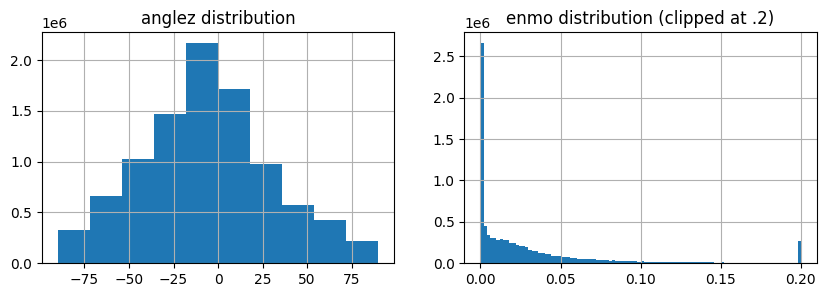

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
trs.anglez.hist(ax=axes[0])
axes[0].set_title('anglez distribution')
trs.enmo.clip(0, .2).hist(ax=axes[1], bins=100)
plt.title('enmo distribution (clipped at .2)');

### Train Events Data 
**Only included for train data since this is what we are predicting** 
* For each night the time of sleep **onset** and **wakeup** is annotated.
* Some nights have NA for either event due to the person not wearing their watch - about  

In [18]:
tre

series_id  night   event      step                 timestamp
0     038441c925bb      1   onset    4992.0  2018-08-14T22:26:00-0400
1     038441c925bb      1  wakeup   10932.0  2018-08-15T06:41:00-0400
2     038441c925bb      2   onset   20244.0  2018-08-15T19:37:00-0400
3     038441c925bb      2  wakeup   27492.0  2018-08-16T05:41:00-0400
4     038441c925bb      3   onset   39996.0  2018-08-16T23:03:00-0400
...            ...    ...     ...       ...                       ...
1017  10f8bc1f7b07     21  wakeup  358416.0  2017-09-28T06:33:00-0400
1018  10f8bc1f7b07     22   onset  370164.0  2017-09-28T22:52:00-0400
1019  10f8bc1f7b07     22  wakeup  375792.0  2017-09-29T06:41:00-0400
1020  10f8bc1f7b07     23   onset  387372.0  2017-09-29T22:46:00-0400
1021  10f8bc1f7b07     23  wakeup  392232.0  2017-09-30T05:31:00-0400

[1022 rows x 5 columns]

In [19]:
tre.isnull().sum() / len(tre)

series_id    0.000000
night        0.000000
event        0.000000
step         0.316047
timestamp    0.316047
dtype: float64

In [20]:
n_nights = (tre.series_id.astype(str) + tre.night.astype(str)).nunique()
(tre.groupby('event')['step'].apply(lambda x: x.isna().sum()) / n_nights).rename('percentage missing')

event
onset     0.315068
wakeup    0.317025
Name: percentage missing, dtype: float64

## Plotting plotting anglez, enmo, events and non-events

### plotting Functions

In [21]:
#| export 
def plot(df_series, df_events, title='time_chunk', extra_cols=[]): 
    fig, ax = plt.subplots(figsize=(15, 5))
    df_series['anglez'].plot(ax=ax, alpha=.3, color='b')
    ax.set_ylabel('anglez', color='b')
    handles = [ax.get_legend_handles_labels()[0][-1]]
    labels = ['anglez']
    for col, color, alpha in extra_cols: 
        df_series[col].plot(ax=ax, alpha=alpha, color=color)
    ax1 = ax.twinx()
    df_series['enmo'].plot(ax=ax1, color='g', alpha=.3)
    ax1.set_ylabel('enmo', color='g')
    
    noon = df_series[df_series.is_noon]
    steps = [(df_series.index[0] - 1, 'noon')]
    for i, step in enumerate(noon.index): 
        steps.append((step, 'noon'))
        ax.axvline(step, color='black', alpha=1, linestyle='-.', label='noon')
        if i == 0: 
            handles.append(ax.get_legend_handles_labels()[0][-1])
            labels.append('noon')
    for i, step in enumerate(df_events.query('event == "onset"').index): 
        steps.append((step, 'onset'))
        ax.axvline(step, color='r', alpha=1, linestyle='-', label='onset')
        if i == 0: 
            handles.append(ax.get_legend_handles_labels()[0][-1])
            labels.append('onset')
    for i, step in enumerate(df_events.query('event == "wakeup"').index): 
        steps.append((step, 'wakeup'))
        ax.axvline(step, color='orange', alpha=1, linestyle='-', label='wakeup')
        if i == 0: 
            handles.append(ax.get_legend_handles_labels()[0][-1])
            labels.append('wakeup')
    steps = sorted(steps)
    for i, (step, kind) in enumerate(steps[1:], start=1): 
        if kind == 'noon': 
            if steps[i - 1][1] == 'onset': 
                ax.axvline(step - steps_in_day // 4, color='purple', alpha=.6, 
                           linestyle='-', label='no_wakeup', linewidth=15.0)
                handles.append(ax.get_legend_handles_labels()[0][-1])
                labels.append('no_wakeup')
            if steps[i - 1][1] == 'noon': 
                ax.axvline(step - steps_in_day // 2, color='brown', alpha=.6, 
                           linestyle='-', label='no_onset', linewidth=15.0)
                handles.append(ax.get_legend_handles_labels()[0][-1])
                labels.append('no_onset')
    ax.legend(loc='upper left', handles=handles, labels=labels)
    ax1.legend()
    plt.suptitle(title)
    plt.show()

def plot_sid(sid = '0ce74d6d2106', days_per_graph = 3, return_dfs=False, extra_cols=[]):
    df = trs[(trs.series_id == sid)]
    df = df.assign(is_noon=df.timestamp.str[11:19] == '12:00:00',
                  mod_step=df.step % steps_in_day).set_index('step')
    dfe_with_nans = tre[(tre.series_id == sid)]
    nights = dfe_with_nans.night.max()
    print('', '*' * 100, '\n', '*' * 38, sid, nights, 'nights', '*' * 38, '\n', '*' * 100)
    dfe = dfe_with_nans.query('step >= 0')
    dfe = dfe.assign(step = dfe.step.astype(int)).set_index('step')
    first_noon_index = int(df[df.is_noon].index[0])
    if first_noon_index > 0:
        df_series = df.iloc[:first_noon_index]
        df_events = dfe.join(df_series[[]], how='inner') 
        plot(df_series, df_events, title=f'sid {sid}: data until first noon')

    for i, chunk in enumerate(range(first_noon_index + 1, len(df), days_per_graph * steps_in_day)): 
        total_chunks = len(df) // (days_per_graph * steps_in_day) + 1
        df_series = df.iloc[chunk: chunk + days_per_graph * steps_in_day]
        df_events = dfe.join(df_series[[]], how='inner')  
        plot(df_series, df_events, extra_cols=extra_cols, 
             title = f'sid {sid}: chunk {i + 1} of {total_chunks}: interval {days_per_graph} days')
    if return_dfs: return df, dfe_with_nans

### Visualizing the first 5 series

 **************************************************************************************************** 
 ************************************** 038441c925bb 23 nights ************************************** 
 ****************************************************************************************************


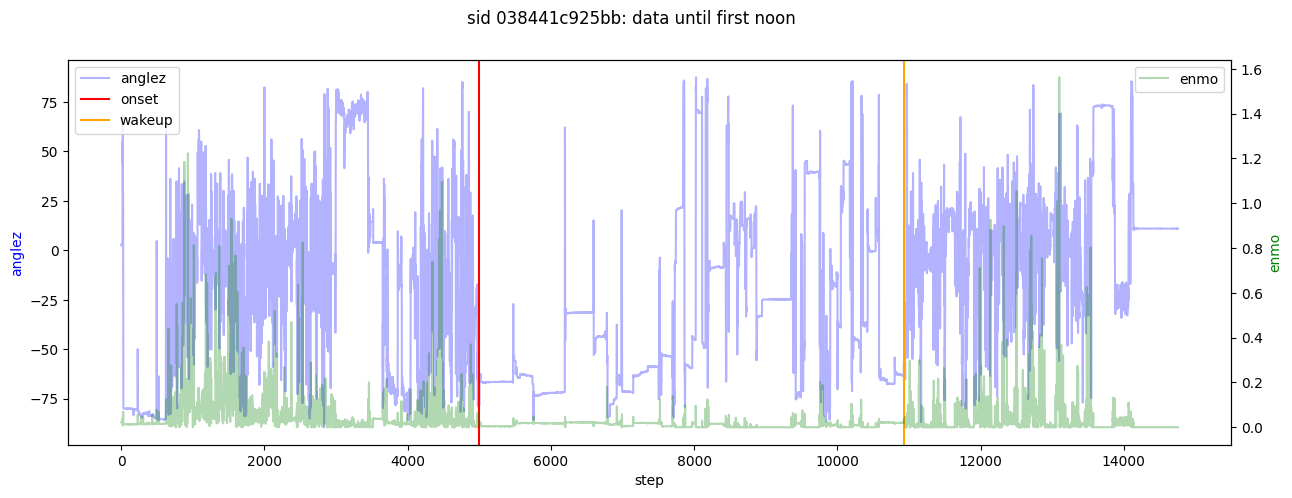

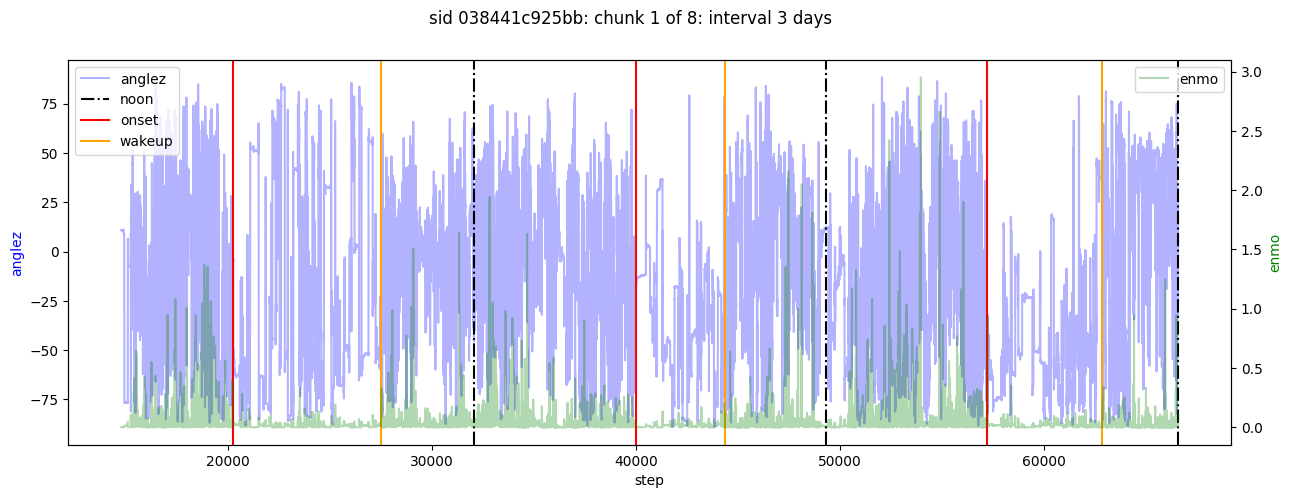

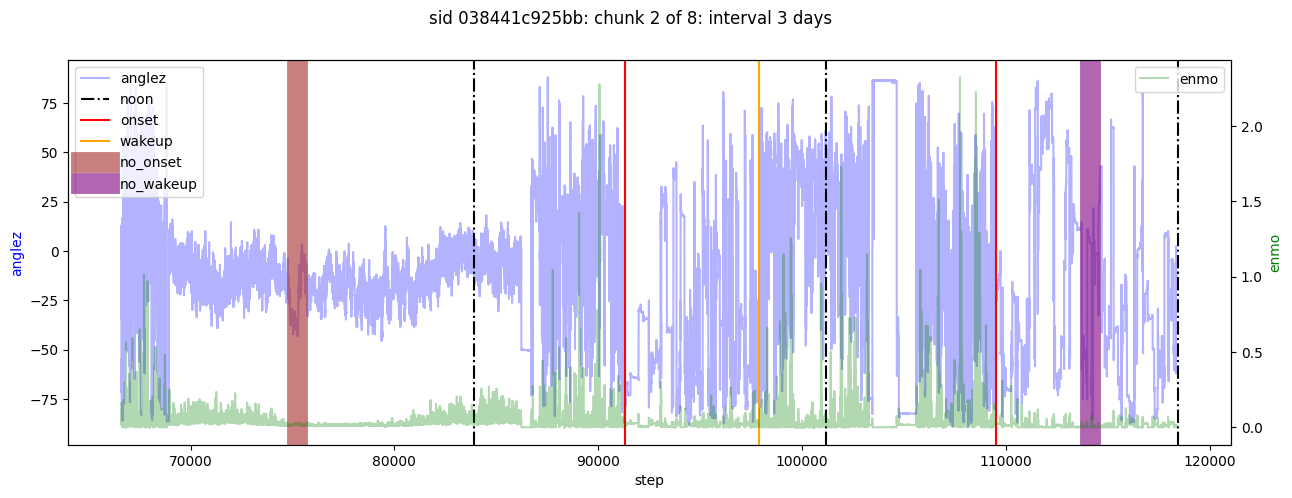

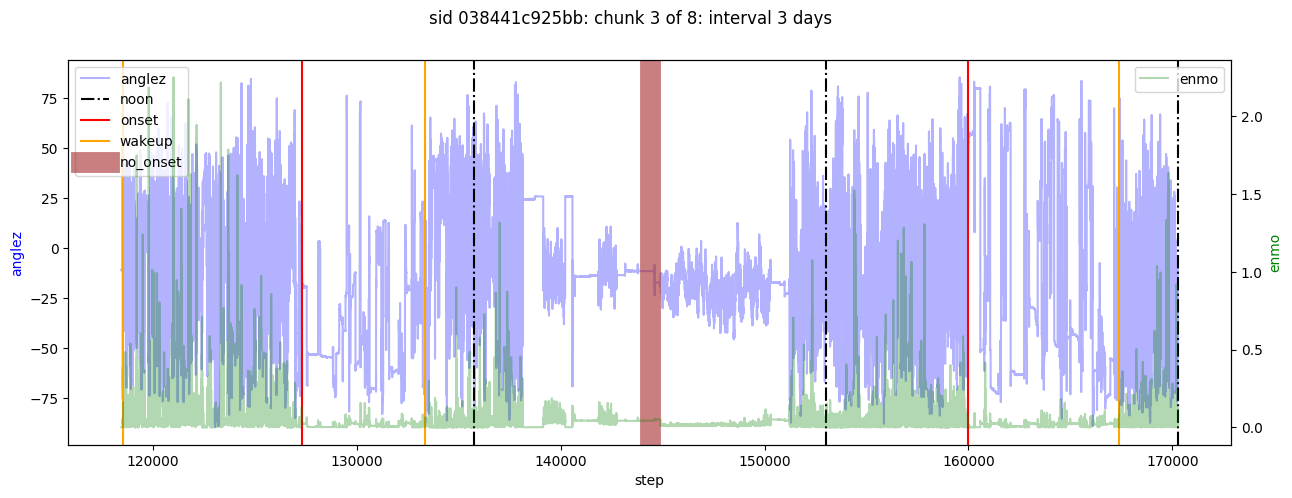

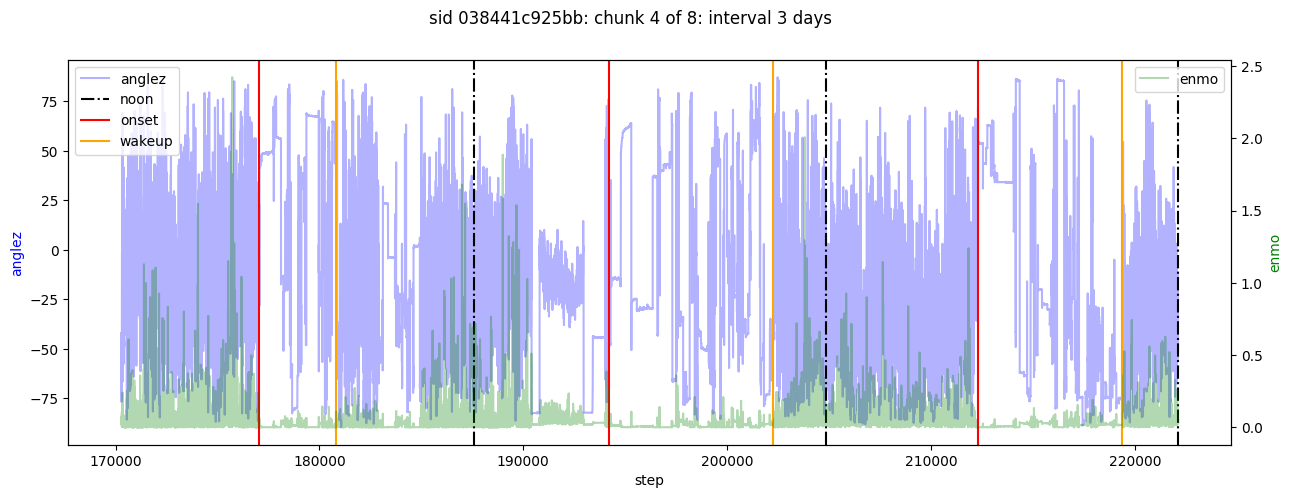

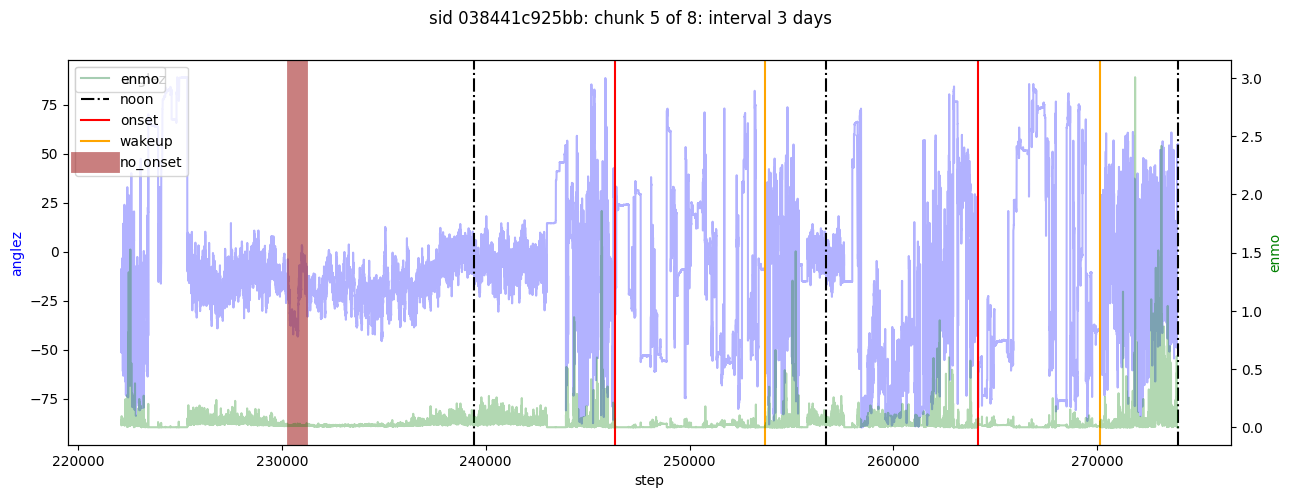

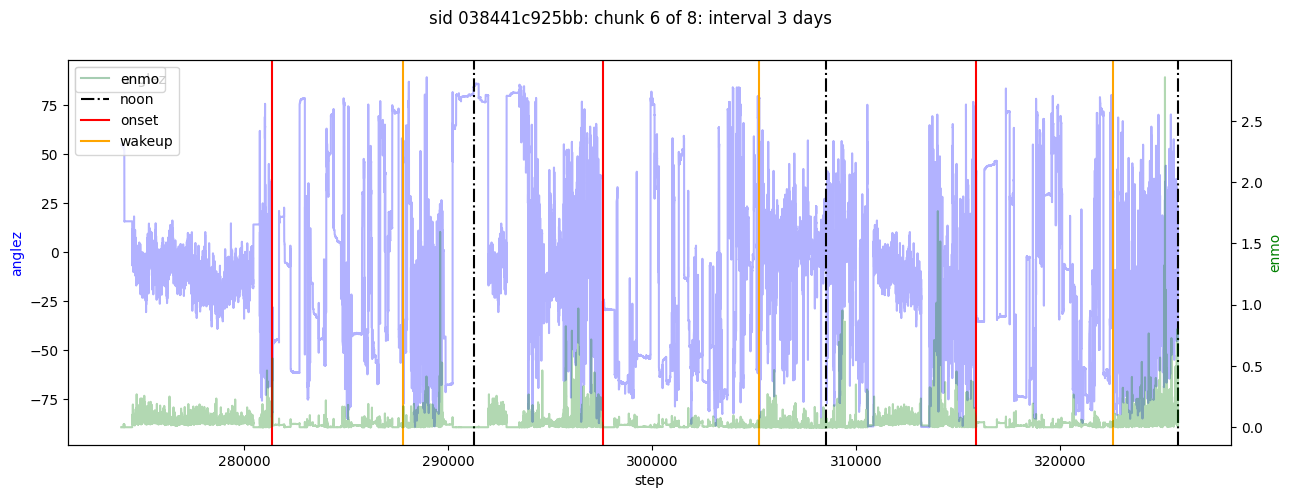

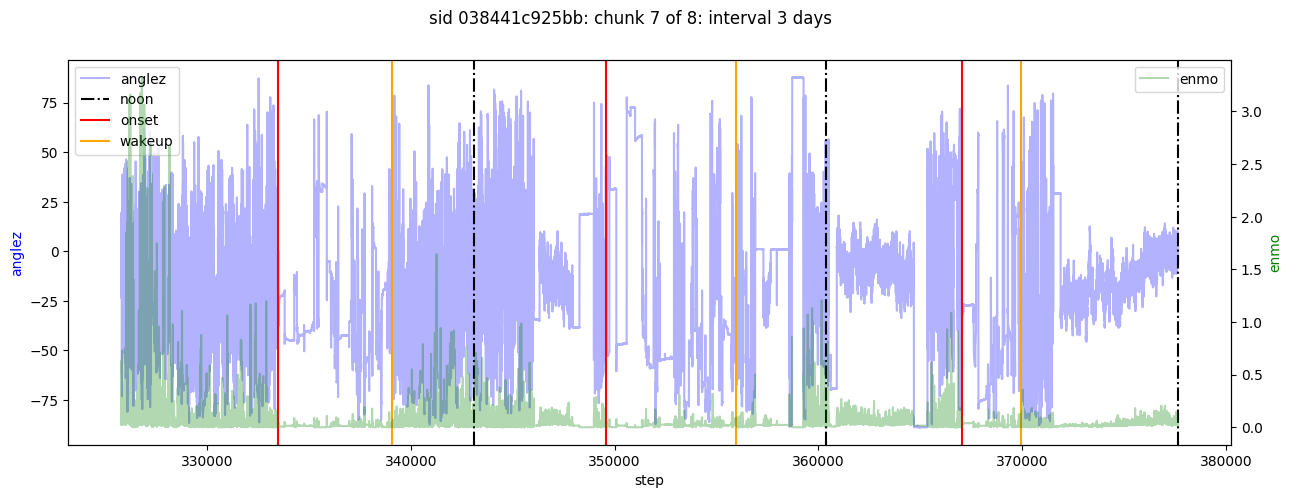

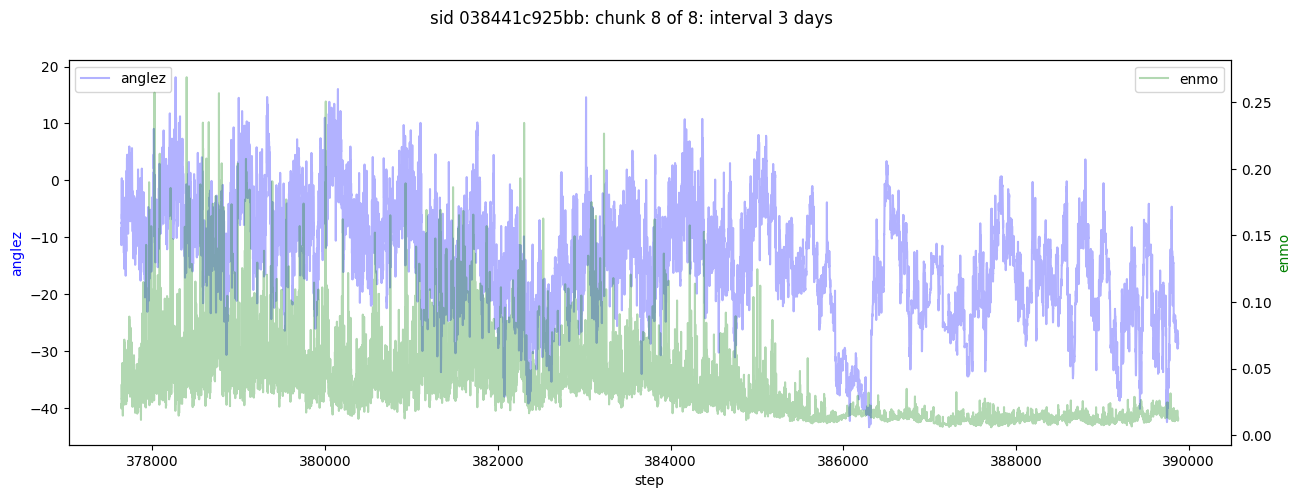

In [25]:
plot_sid(sids[0])

 **************************************************************************************************** 
 ************************************** 03d92c9f6f8a 37 nights ************************************** 
 ****************************************************************************************************


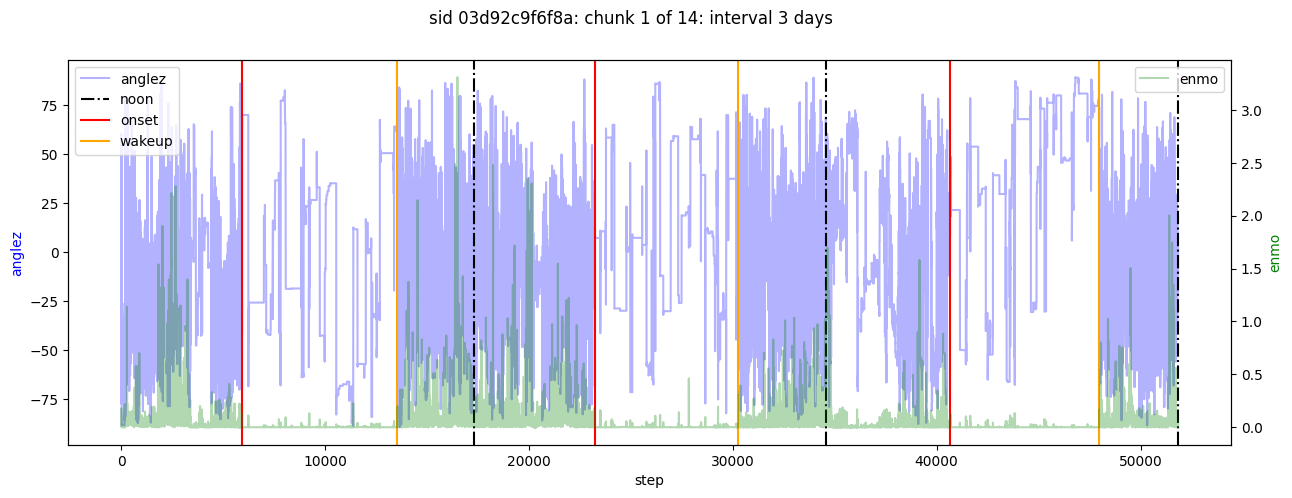

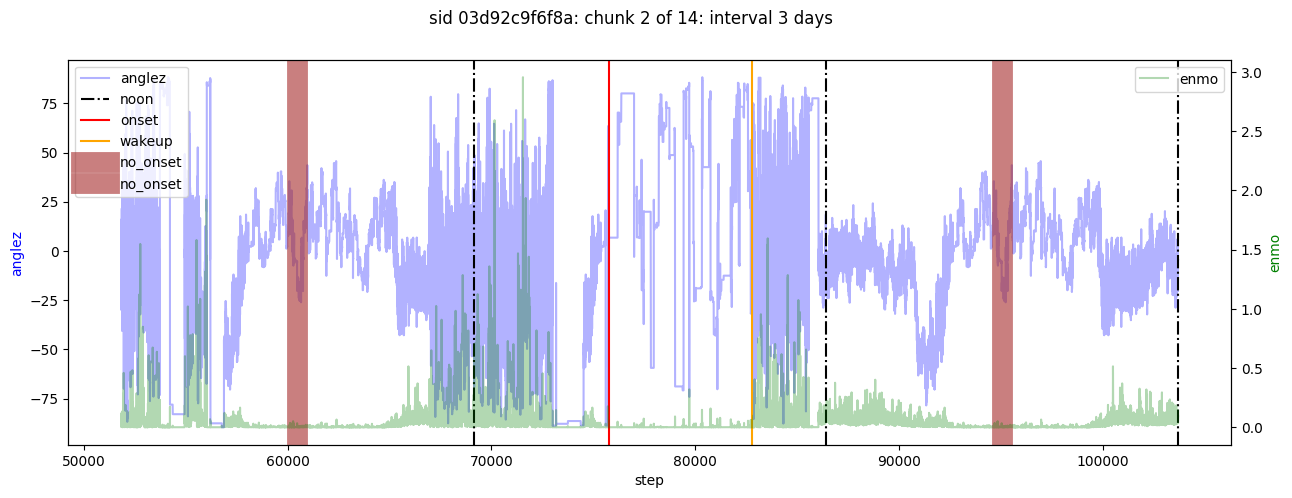

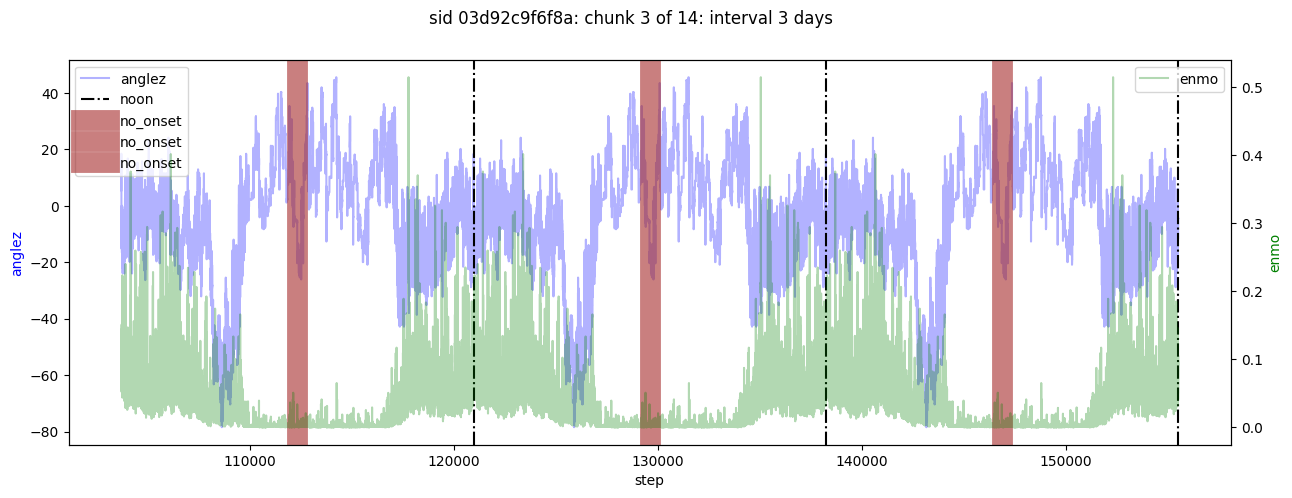

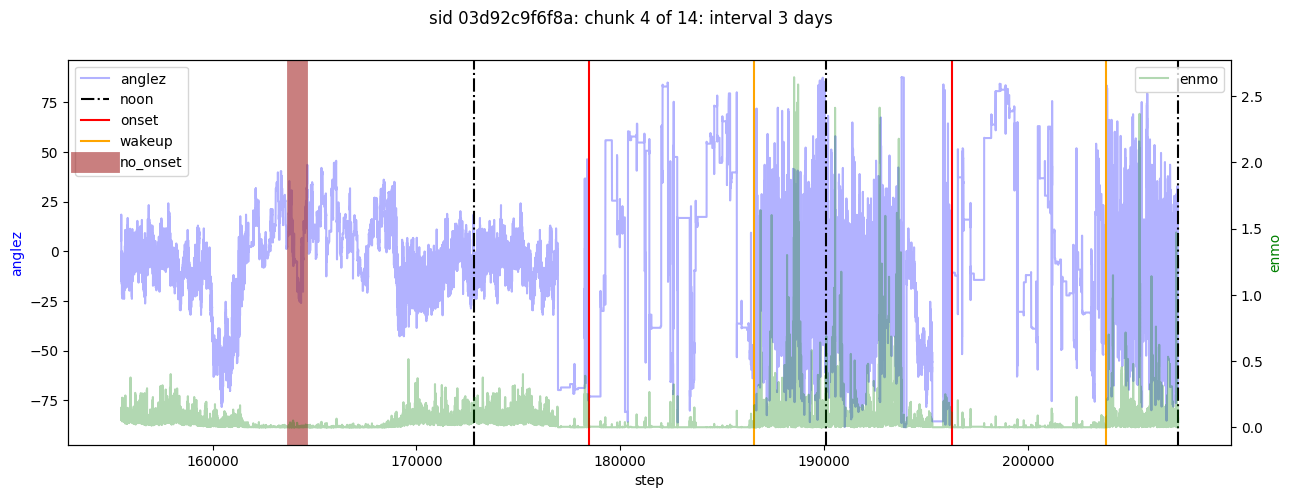

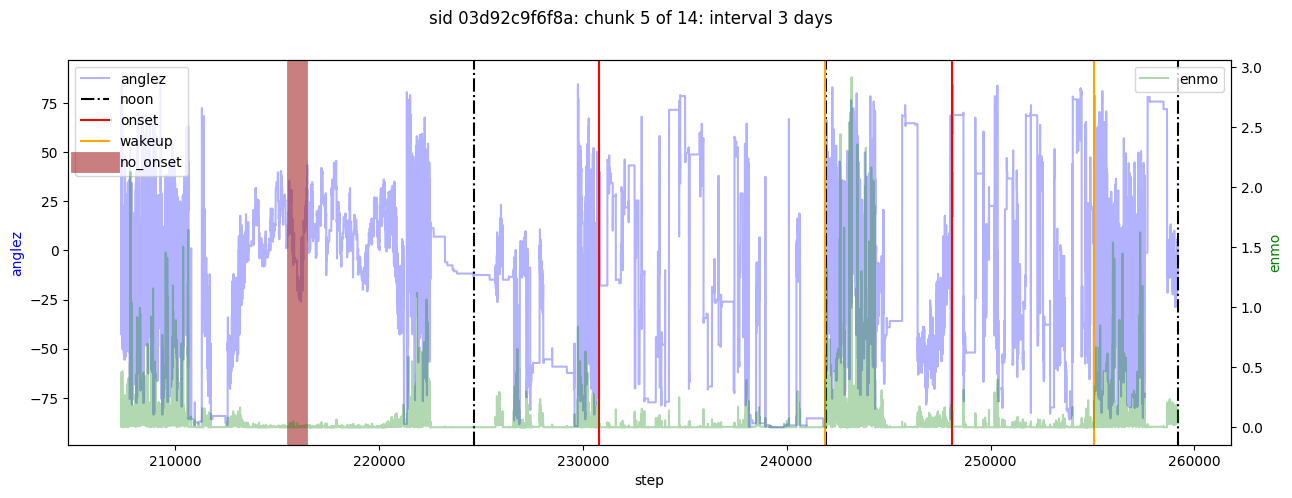

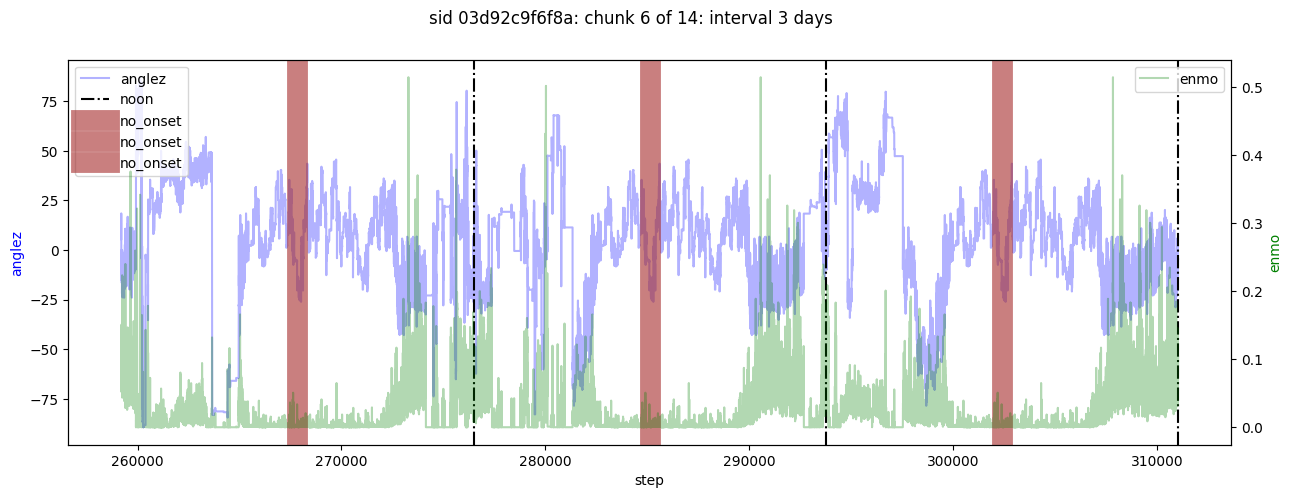

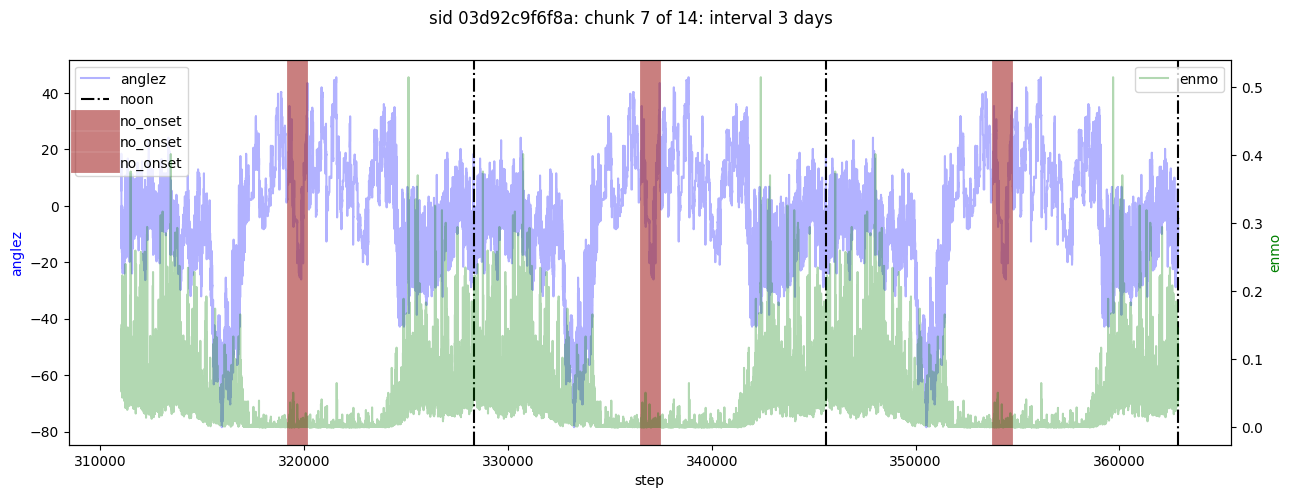

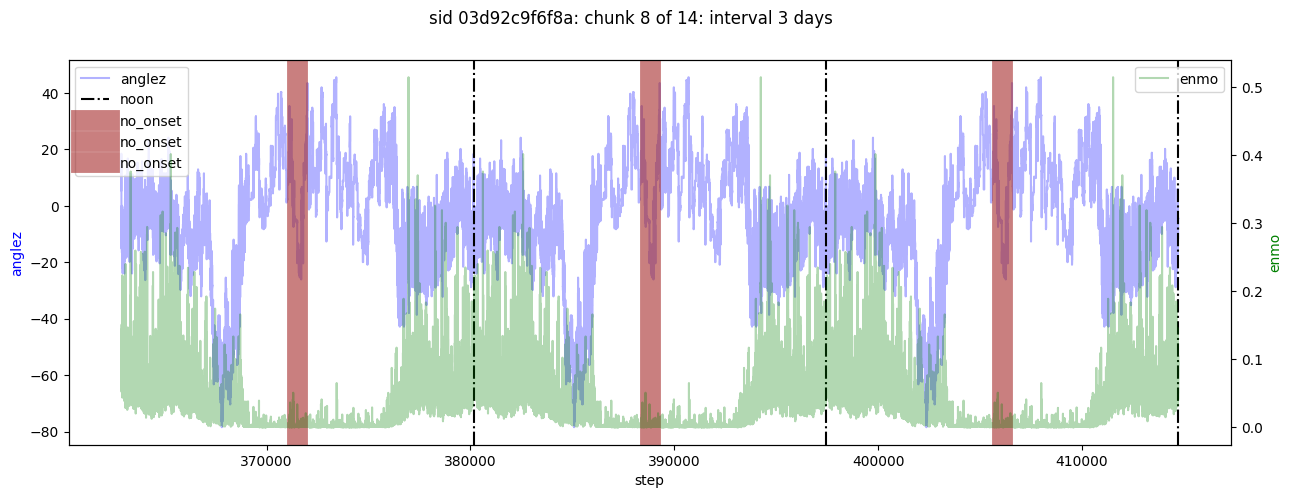

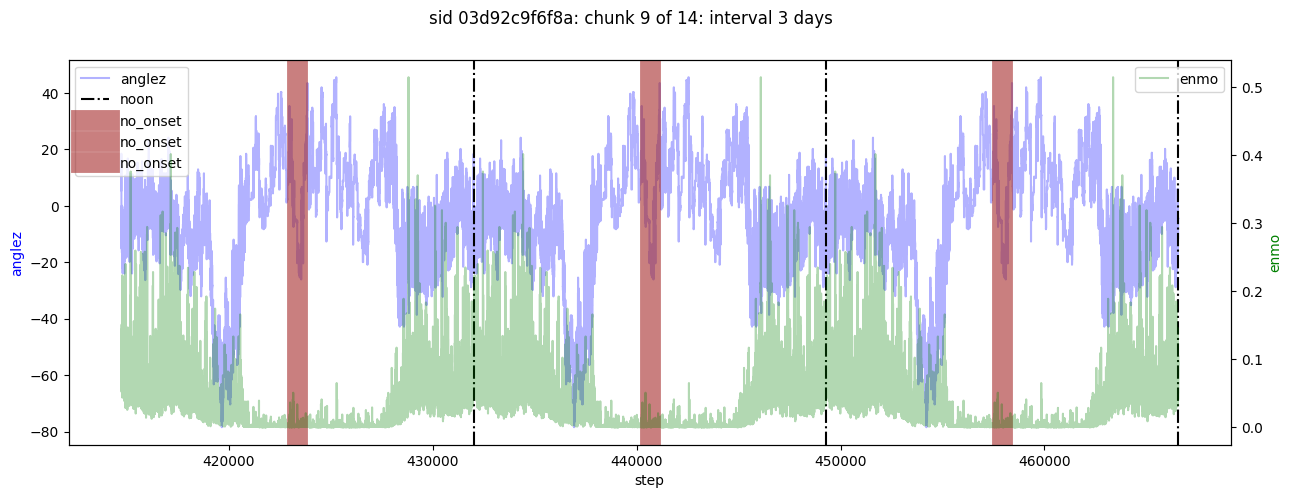

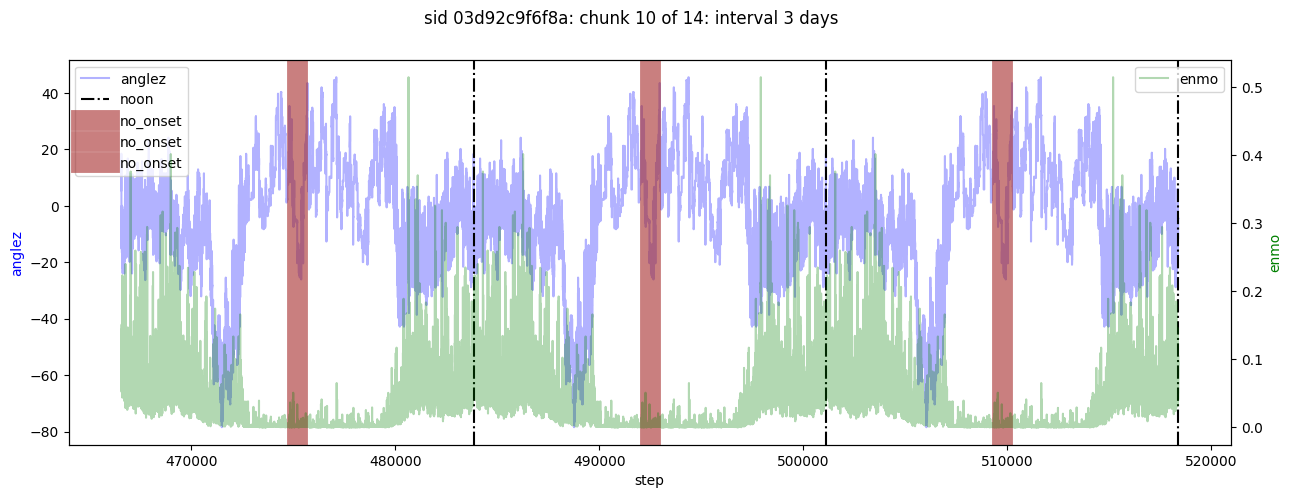

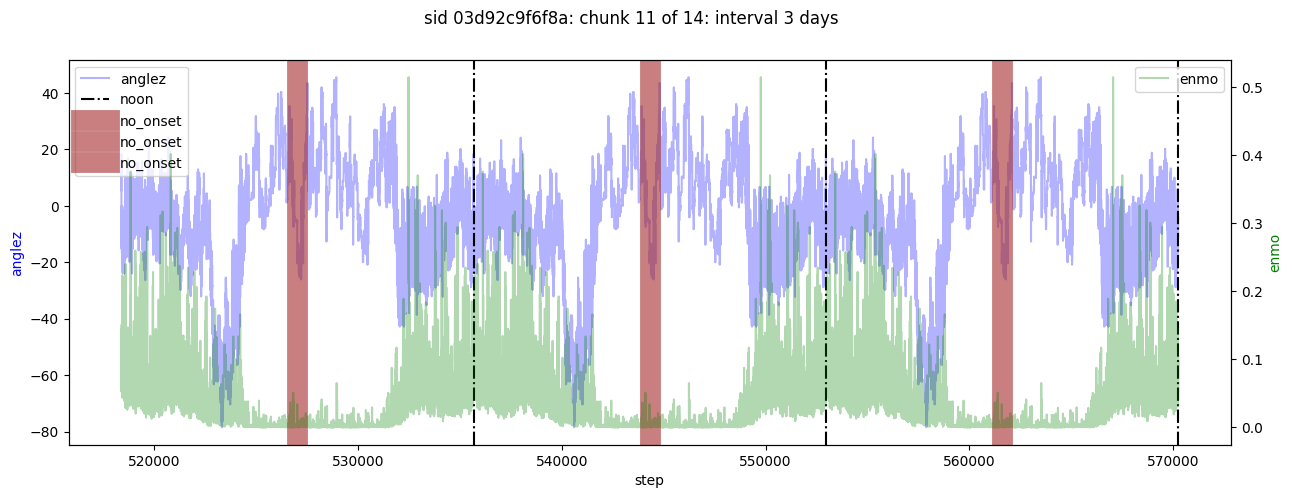

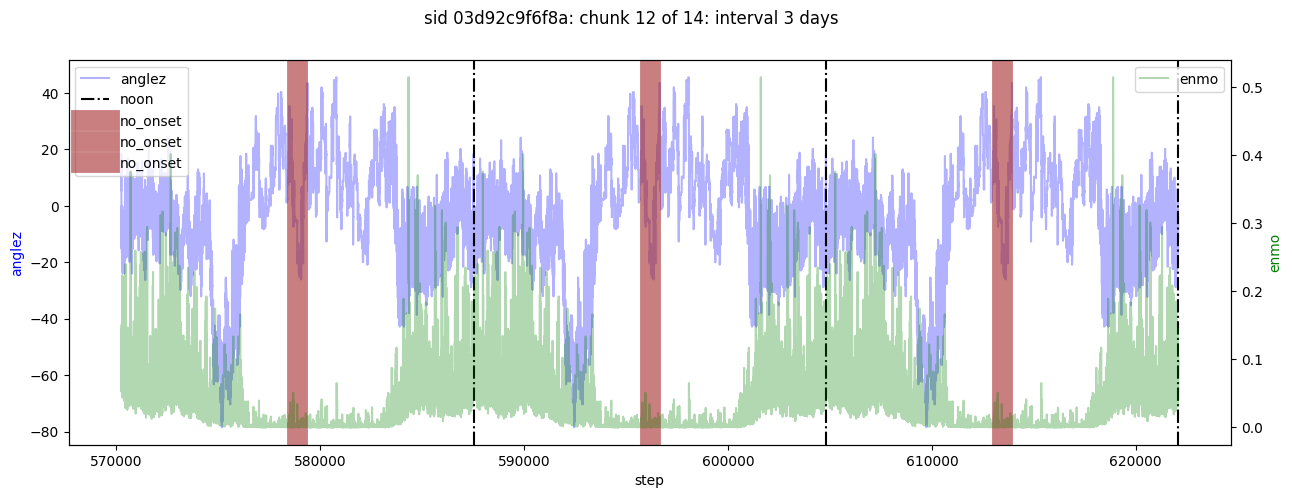

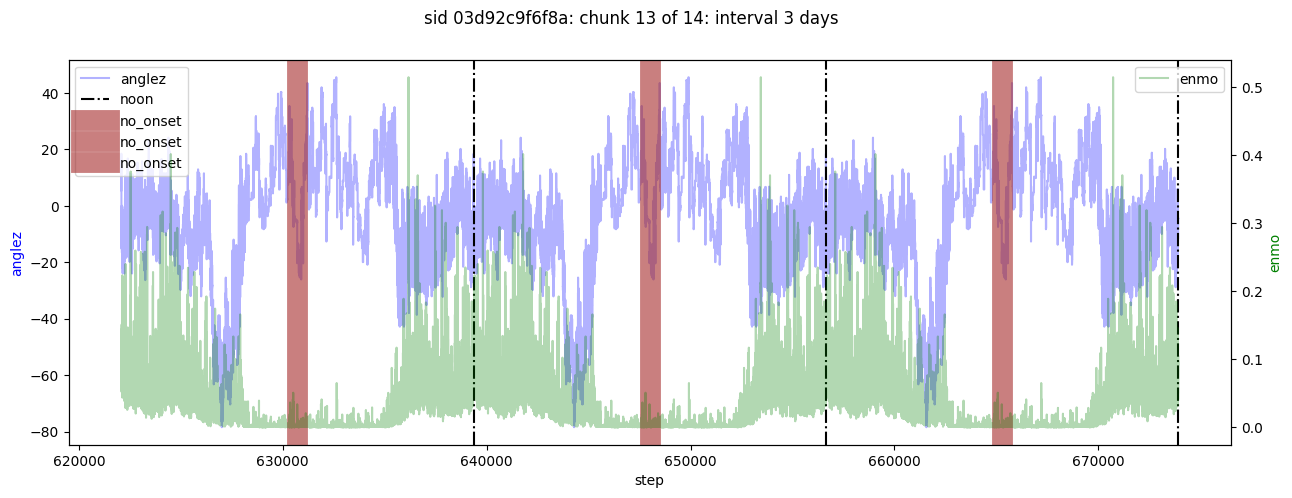

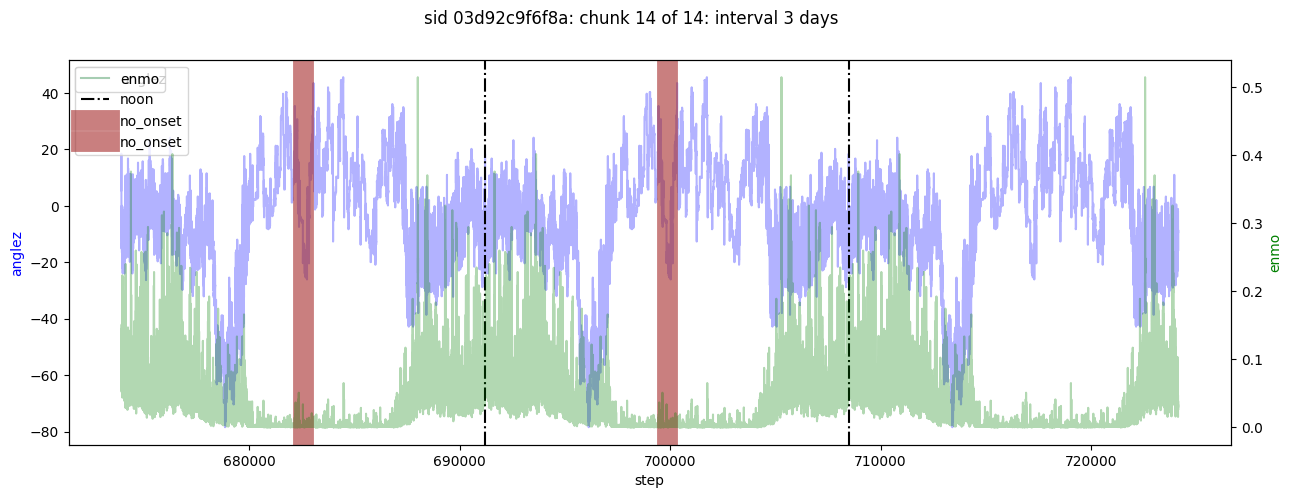

In [28]:
plot_sid(sids[1])

 **************************************************************************************************** 
 ************************************** 0402a003dae9 24 nights ************************************** 
 ****************************************************************************************************


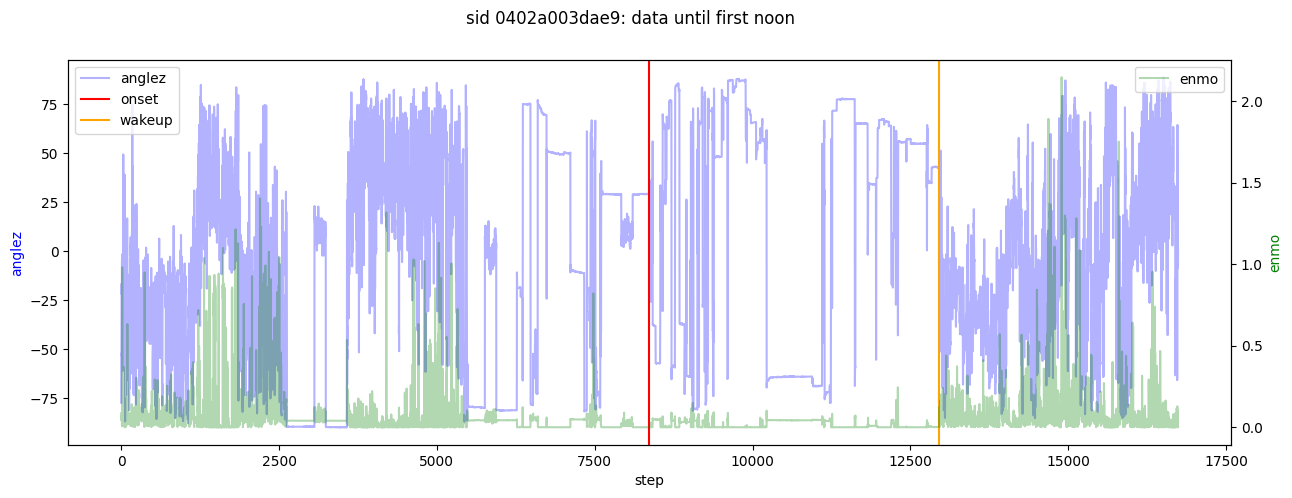

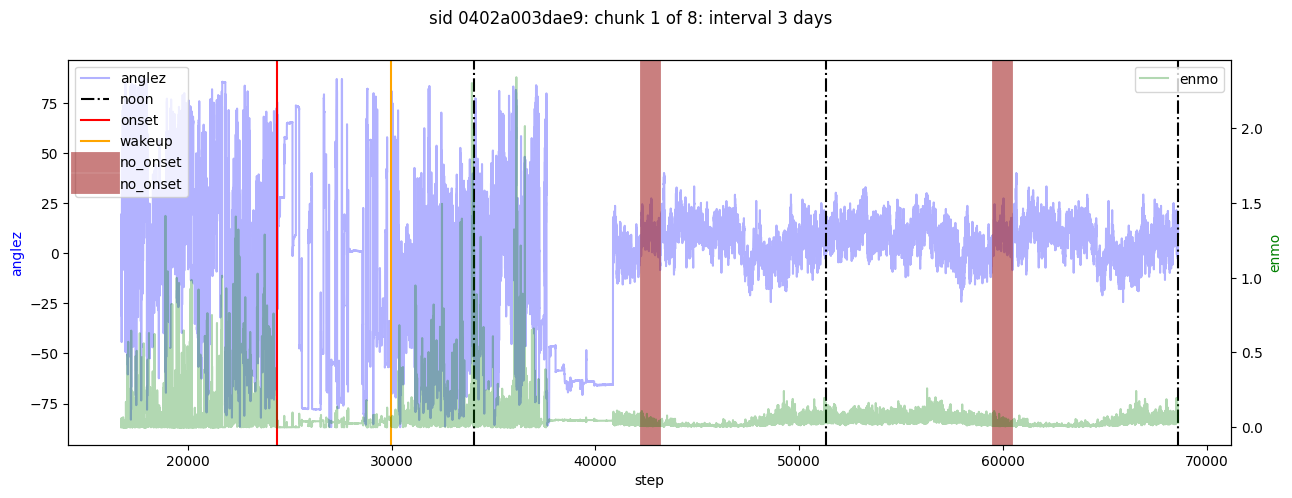

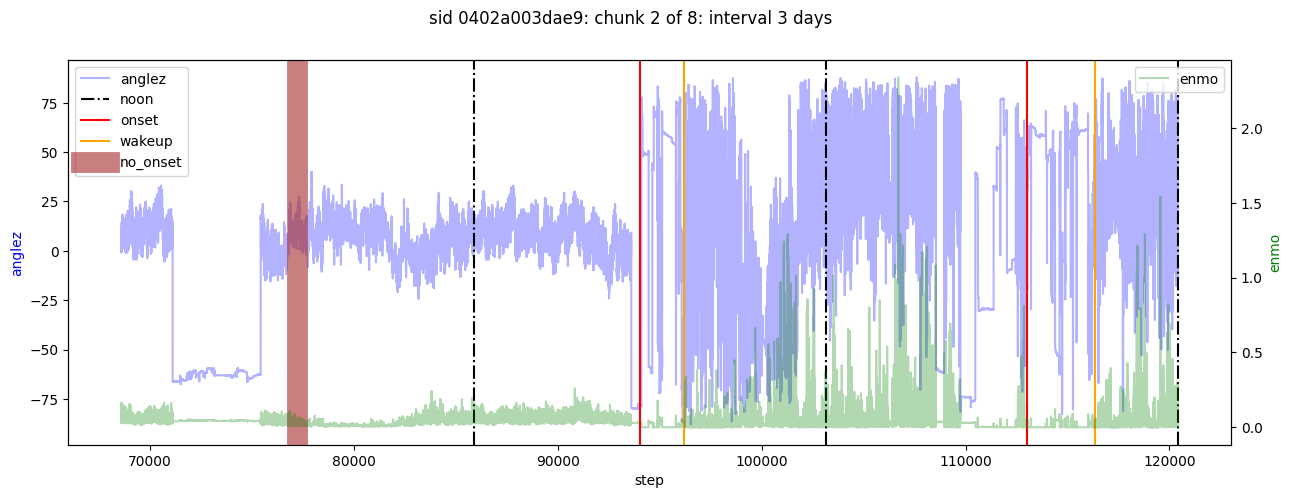

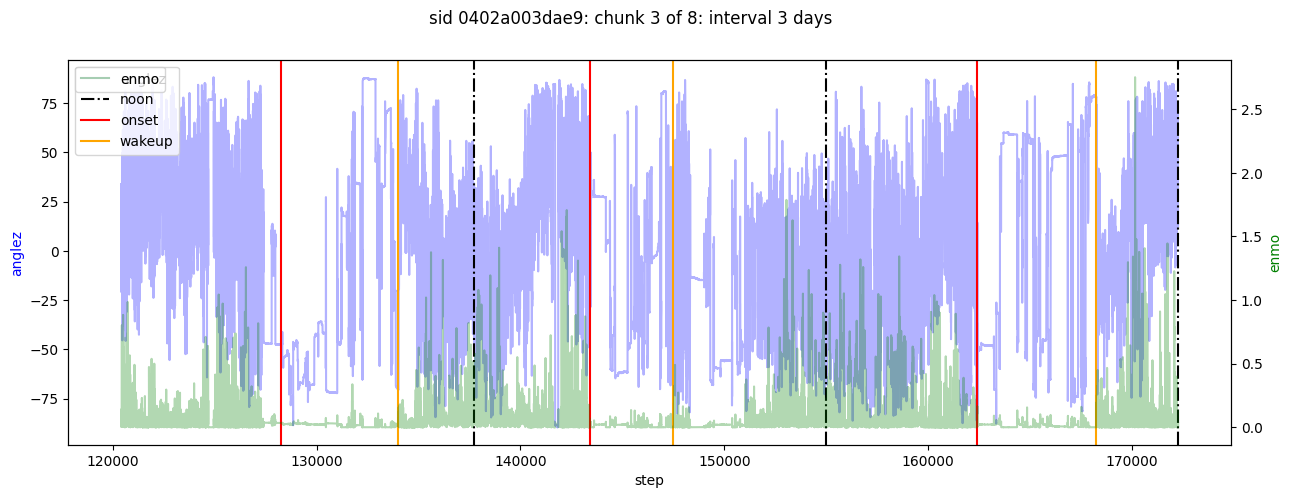

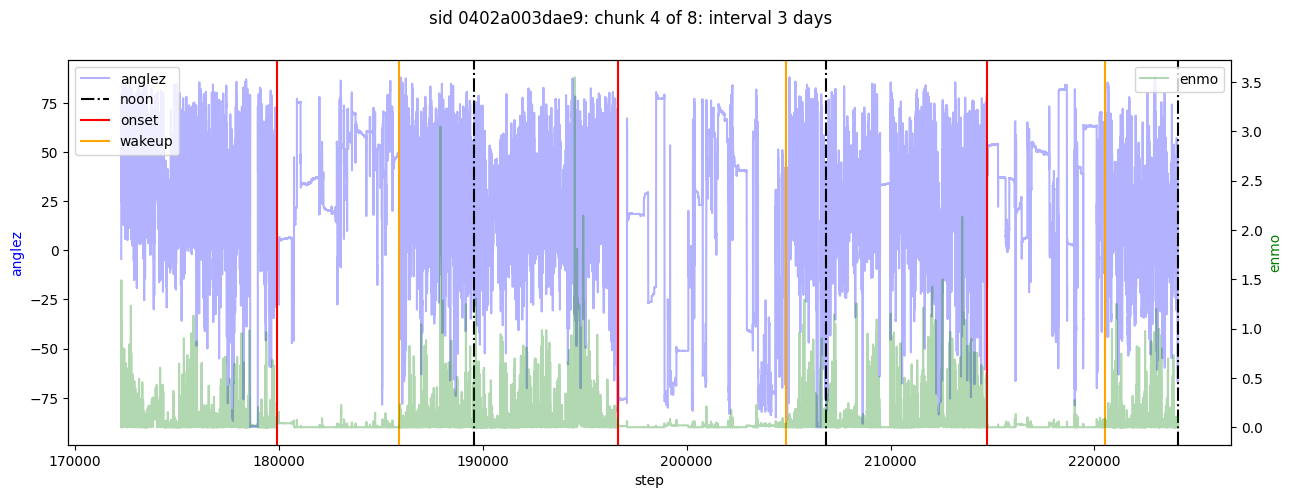

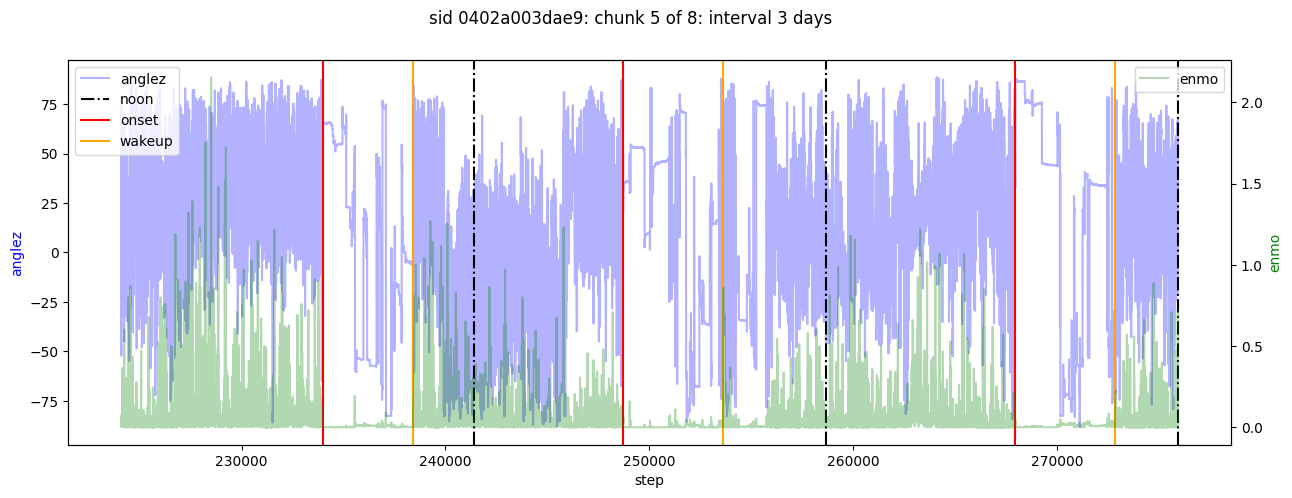

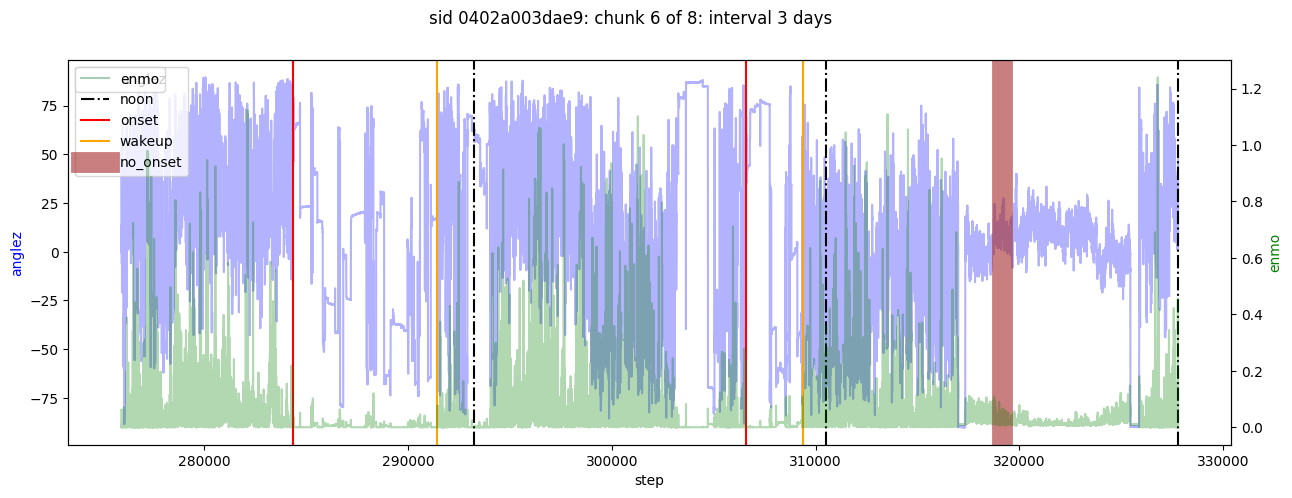

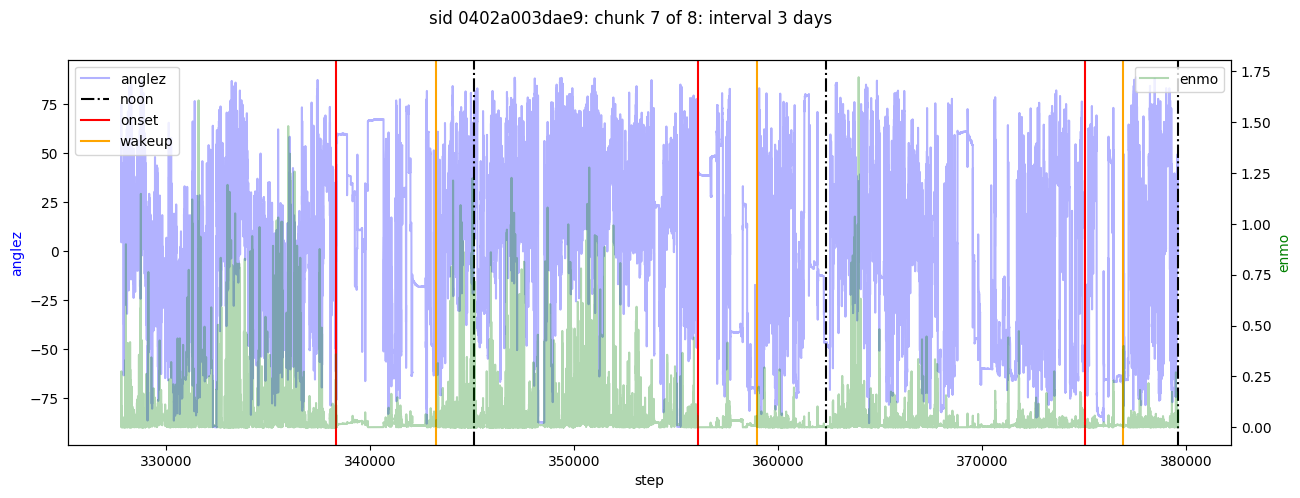

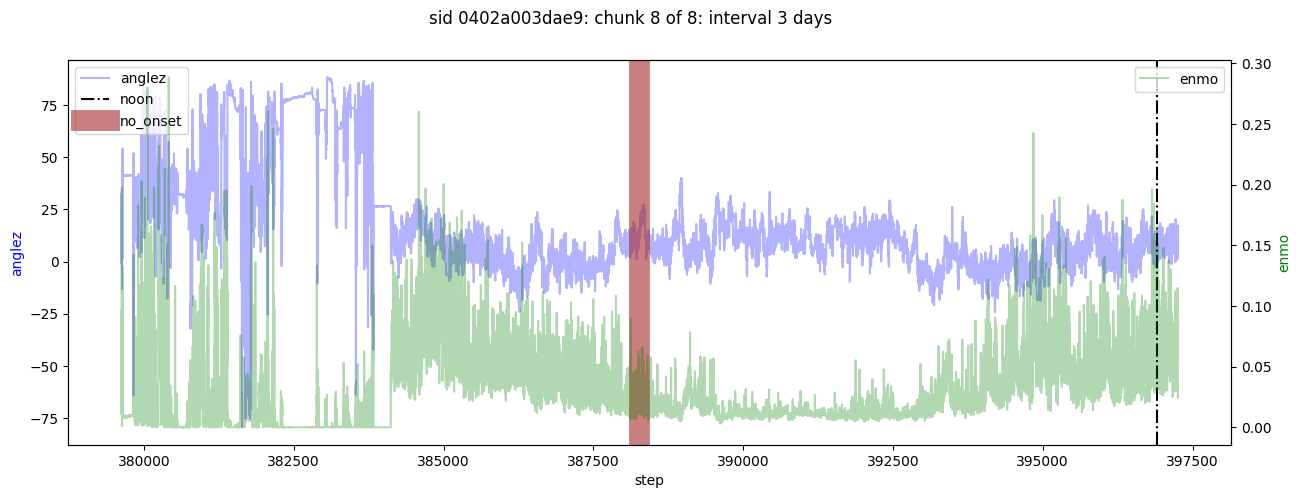

In [29]:
plot_sid(sids[2])

 **************************************************************************************************** 
 ************************************** 04f547b8017d 37 nights ************************************** 
 ****************************************************************************************************


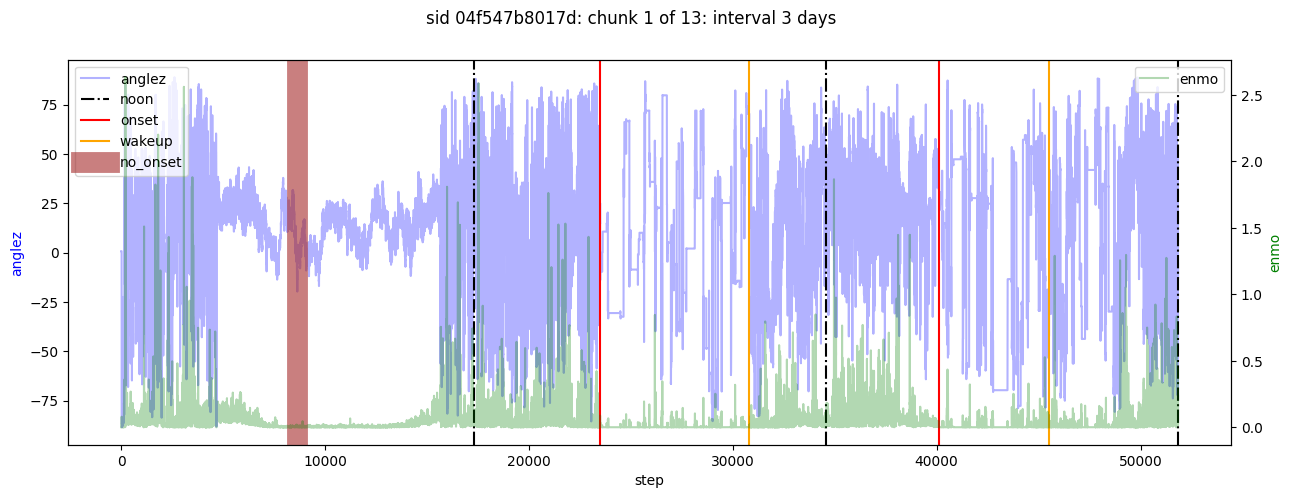

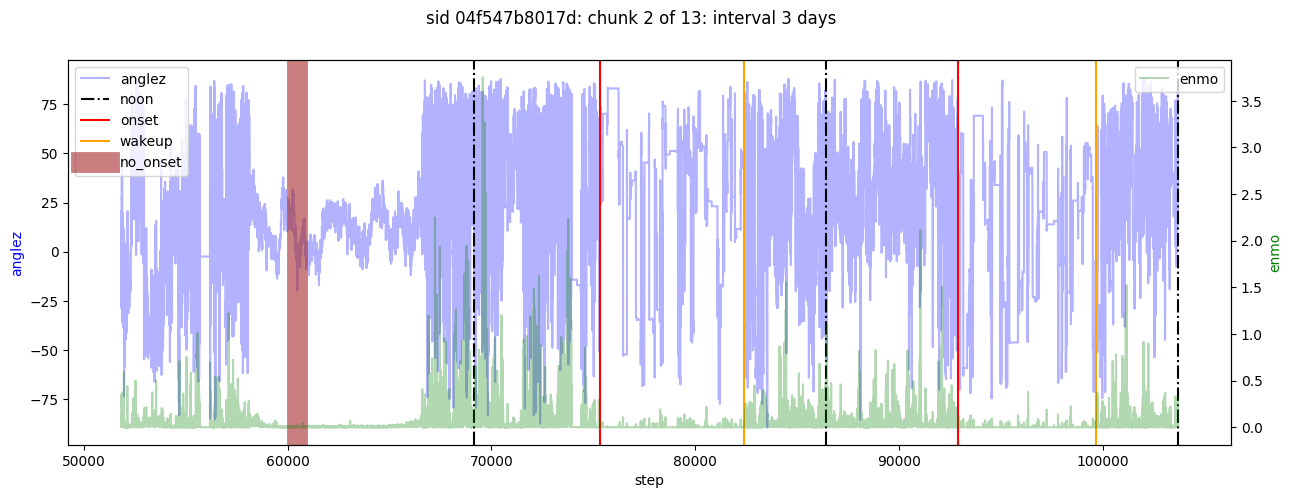

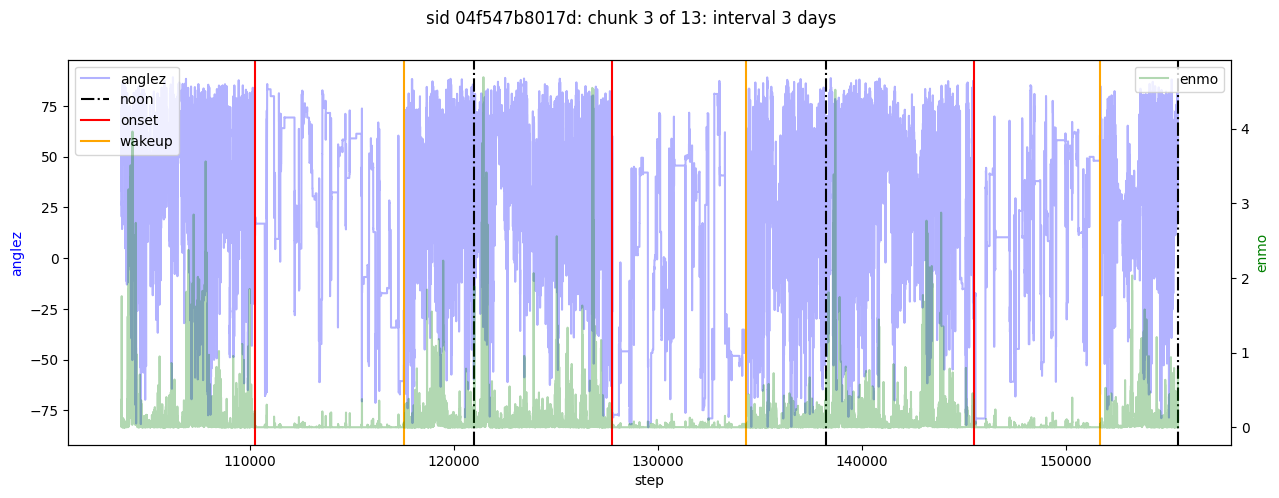

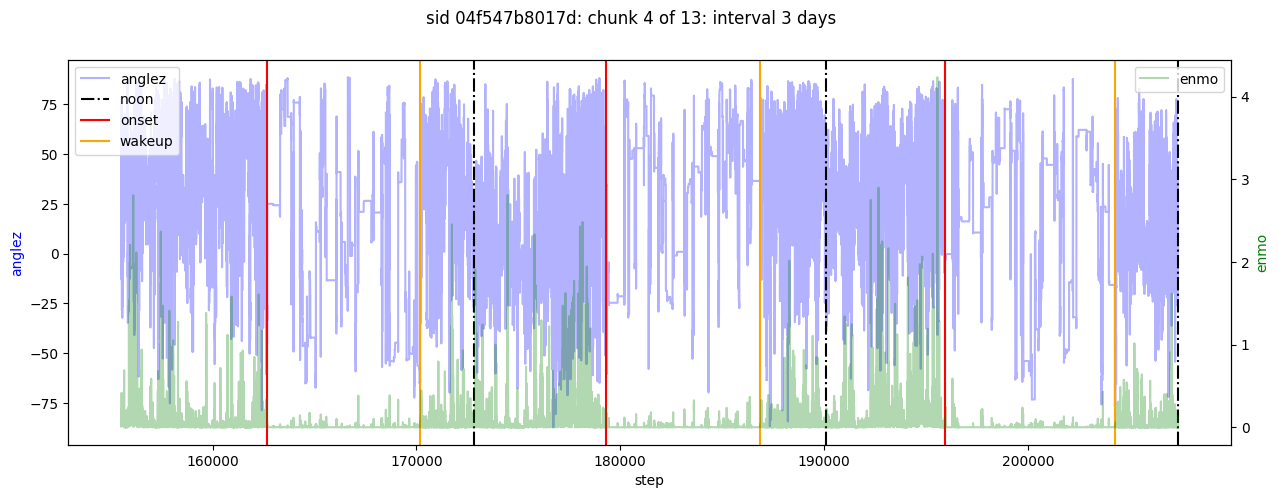

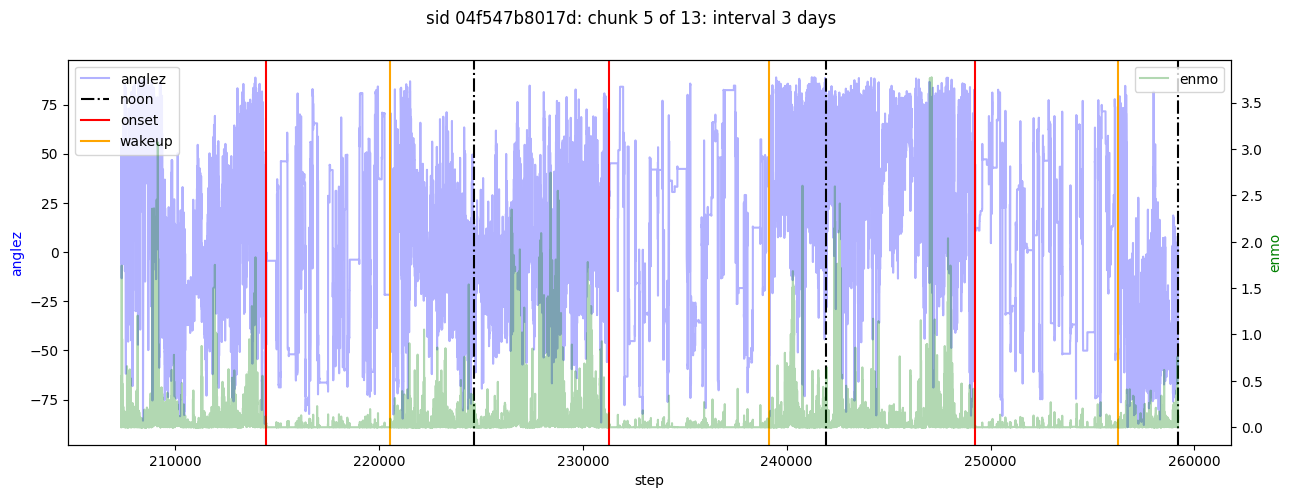

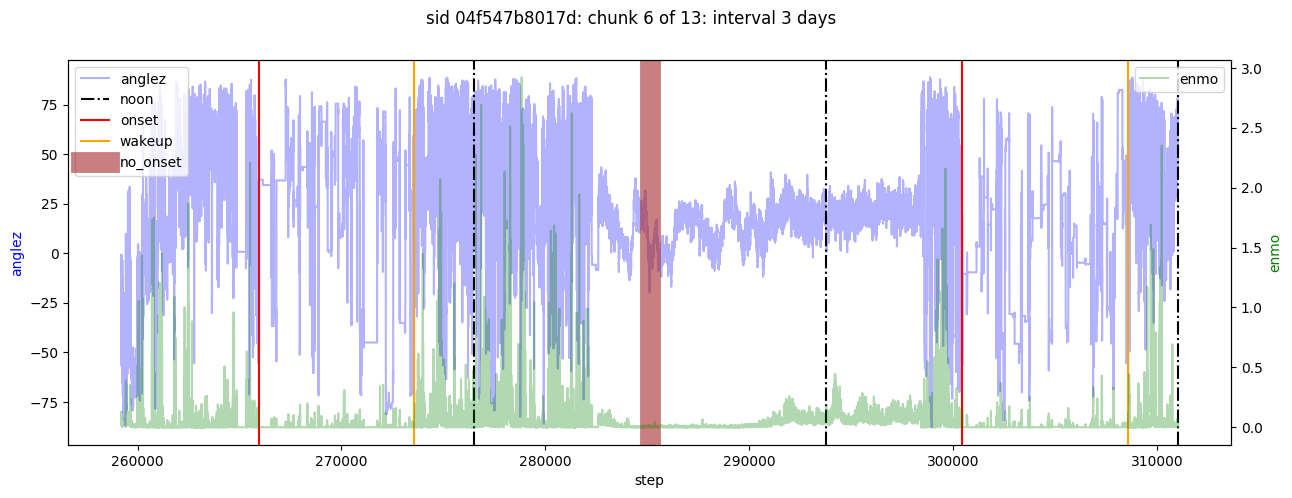

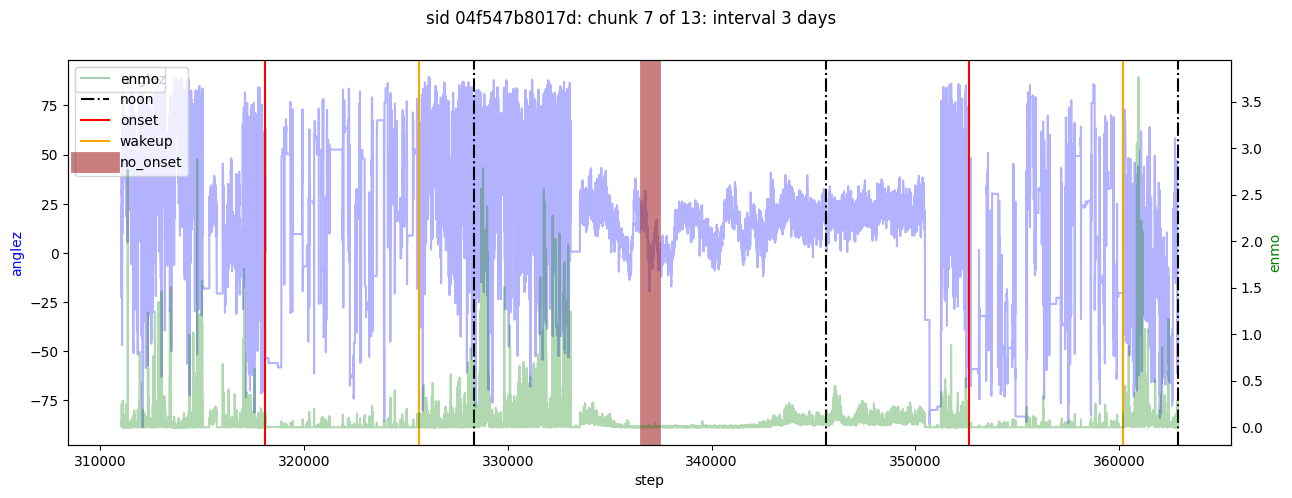

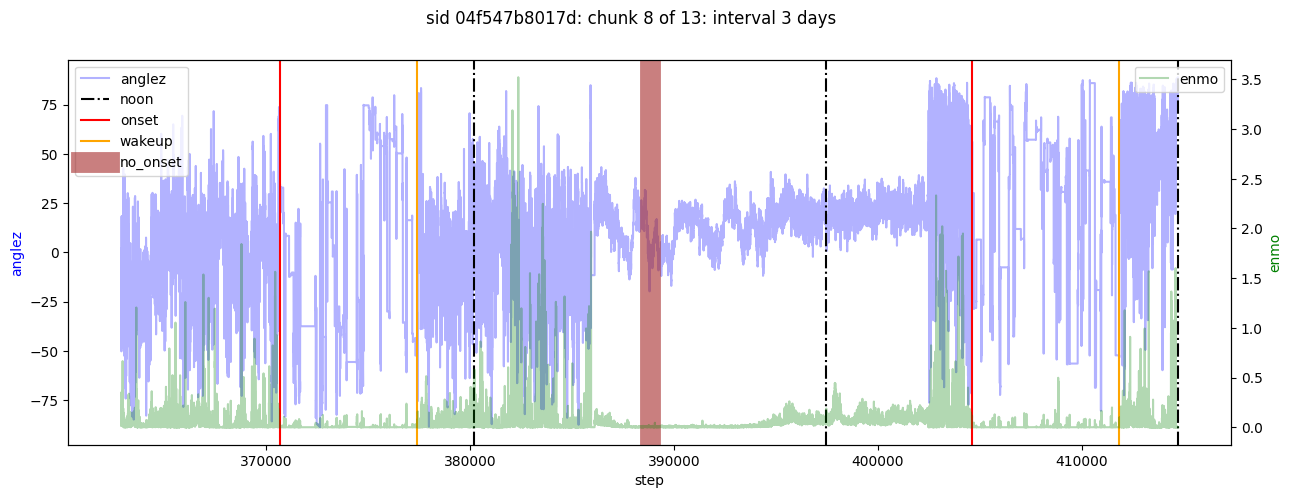

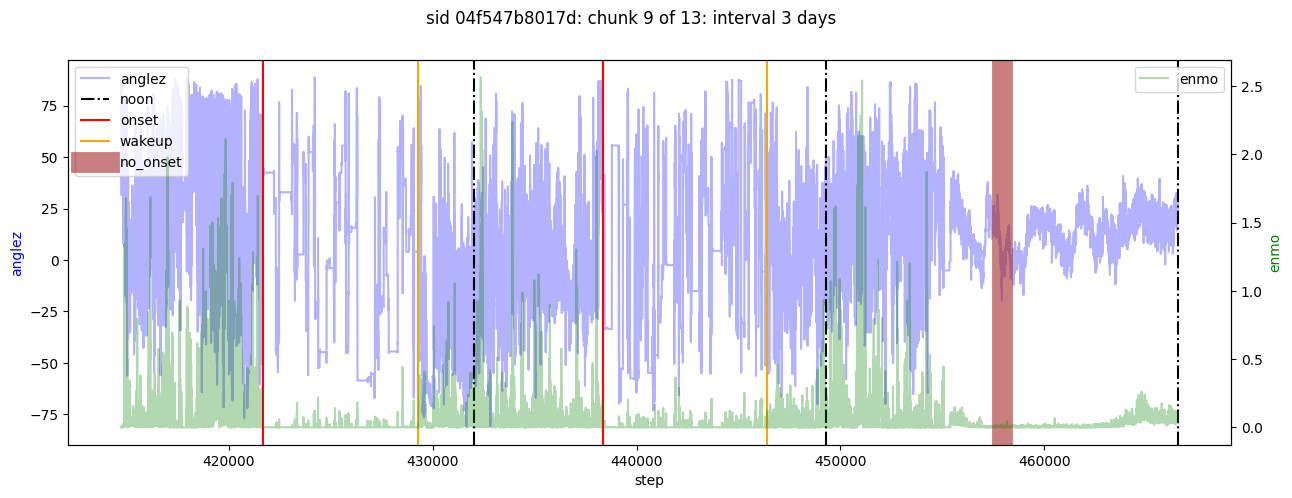

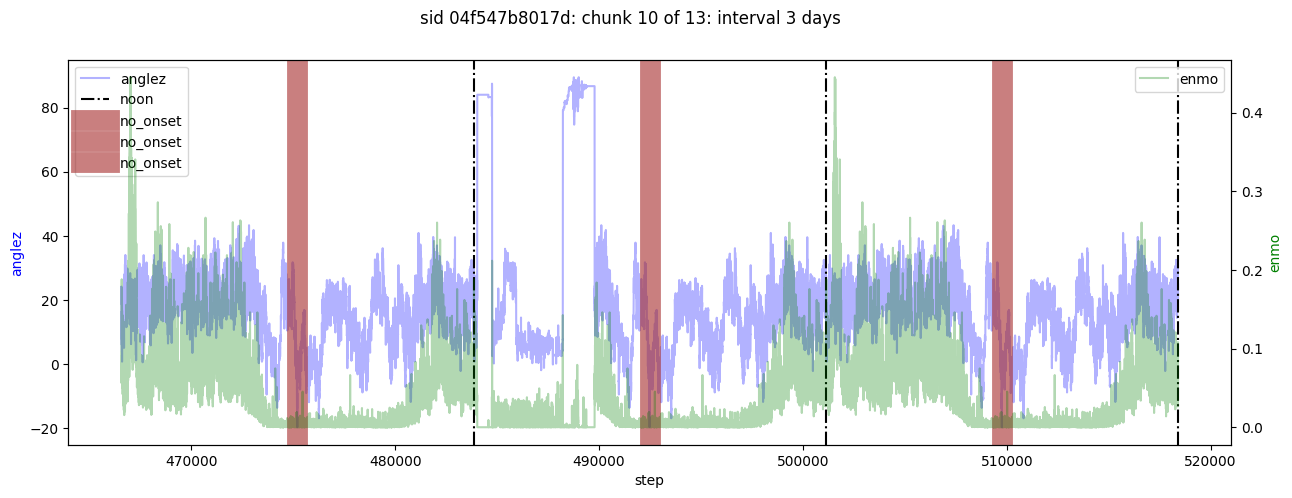

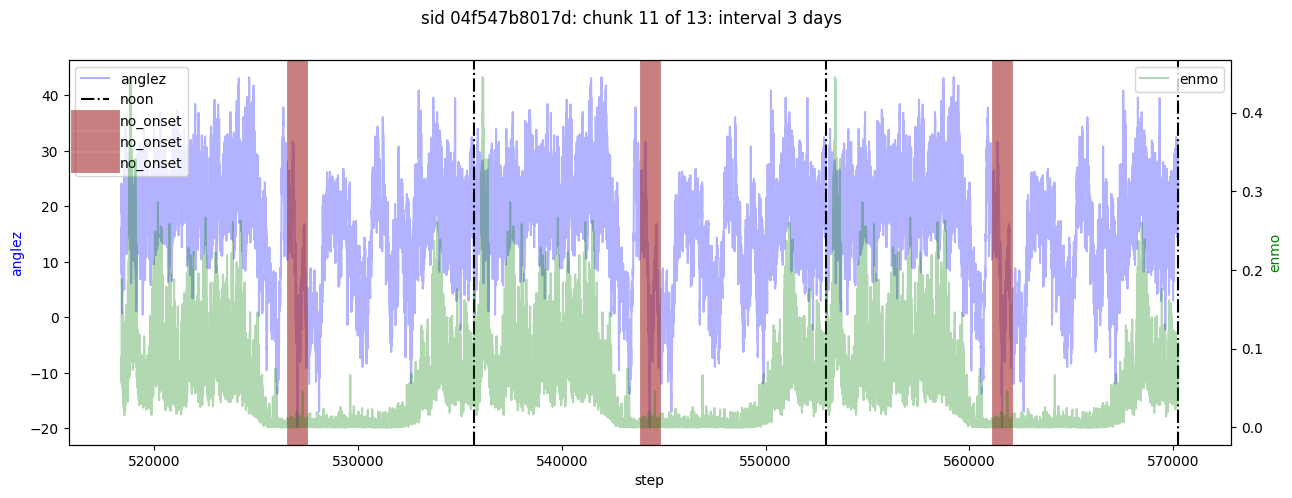

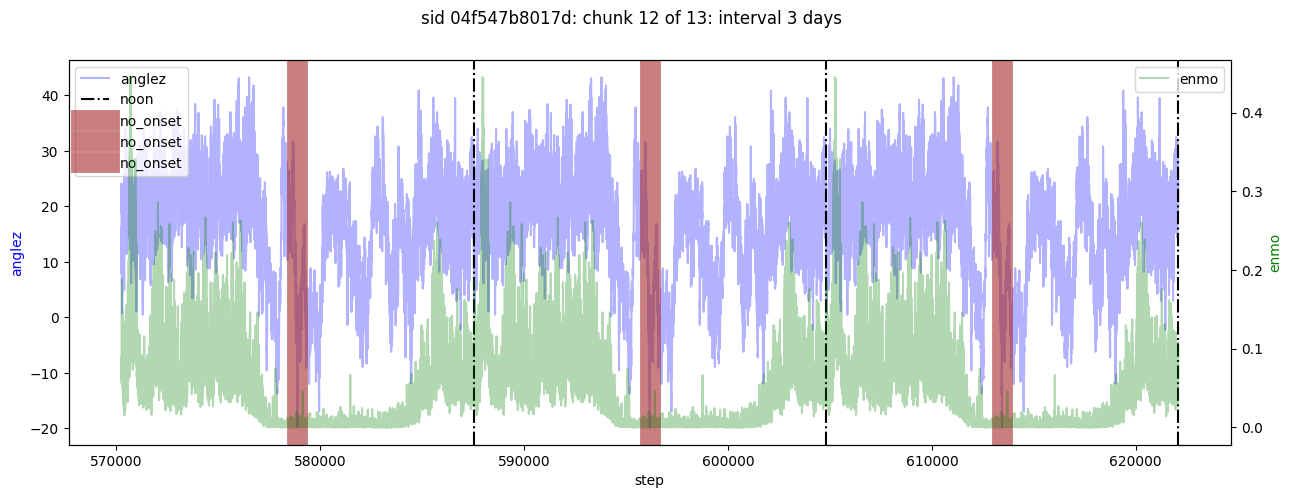

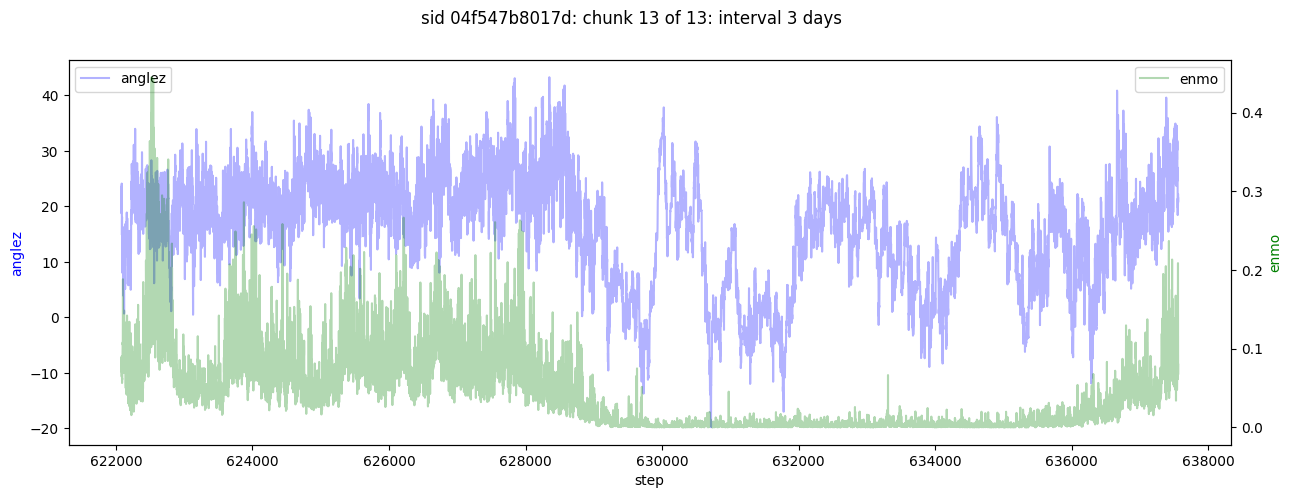

In [30]:
plot_sid(sids[3])

 **************************************************************************************************** 
 ************************************** 05e1944c3818 8 nights ************************************** 
 ****************************************************************************************************


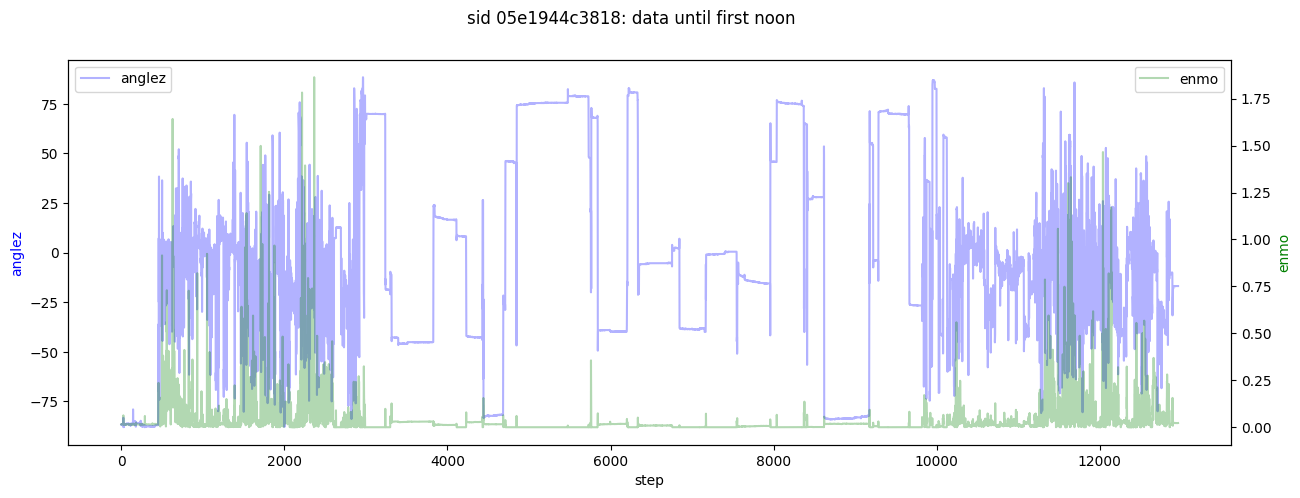

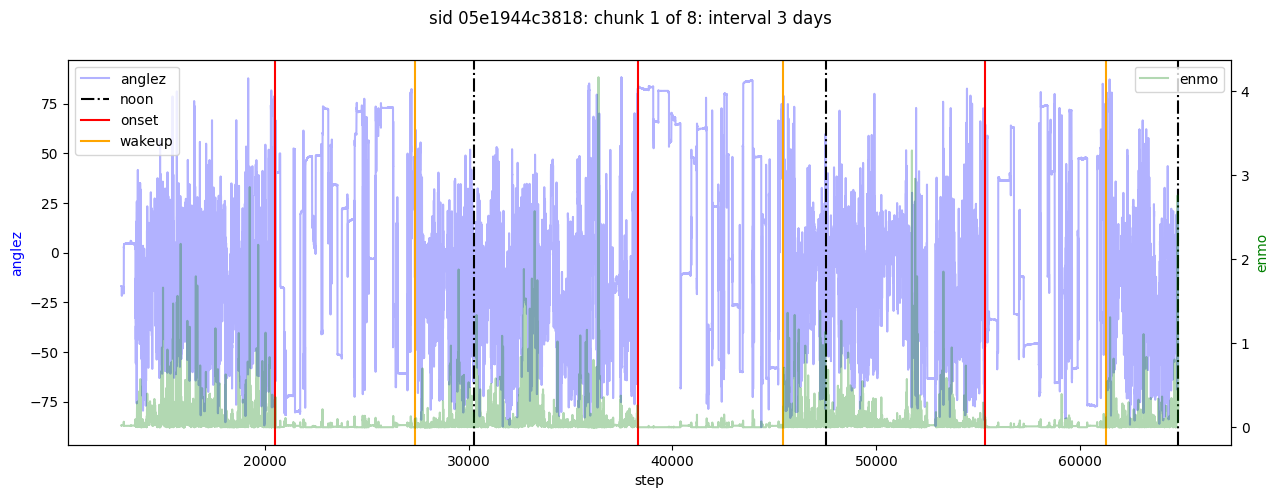

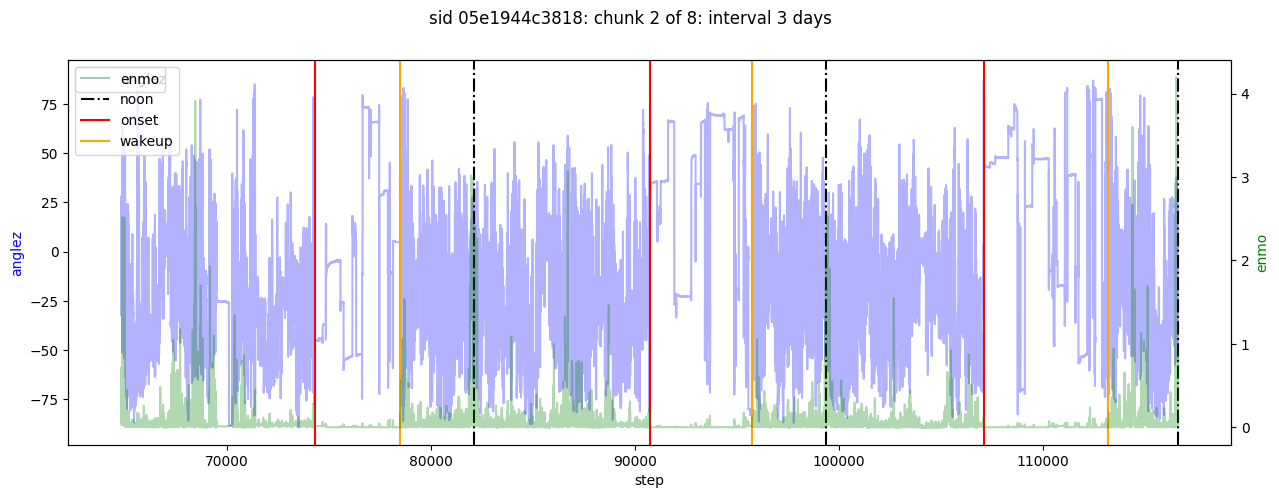

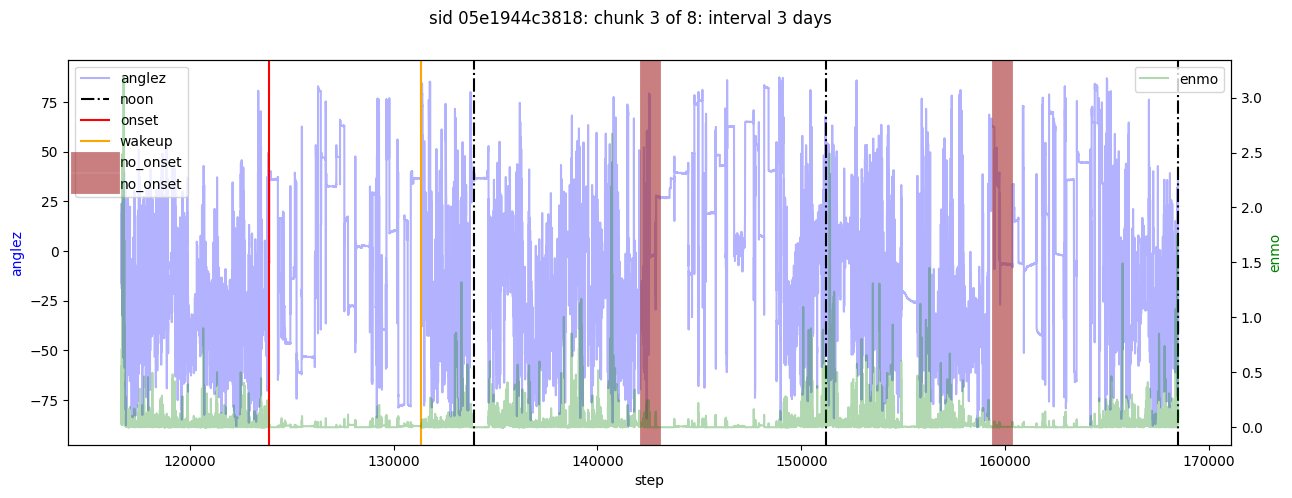

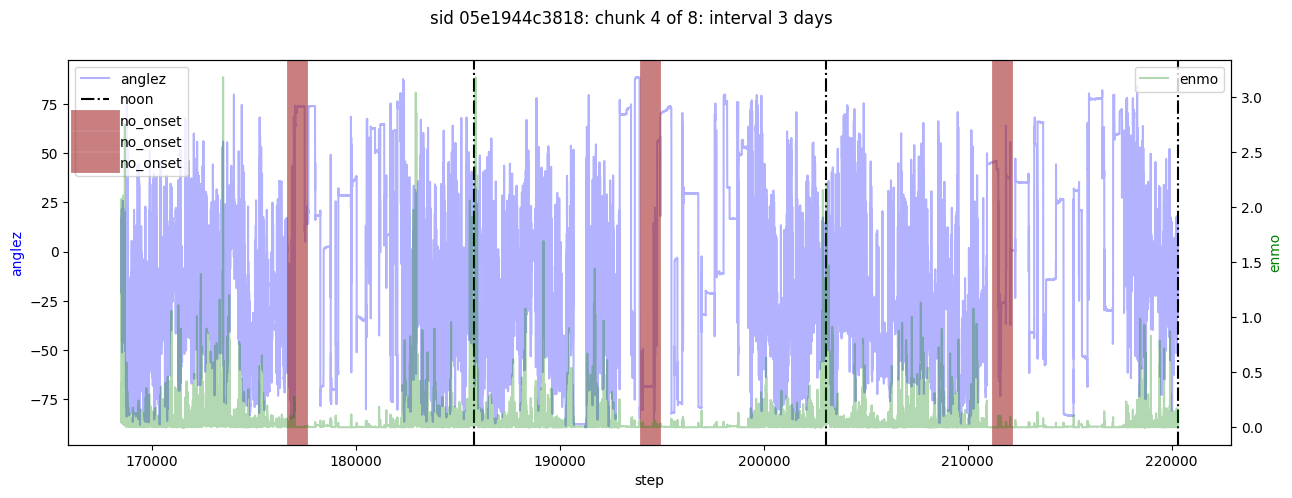

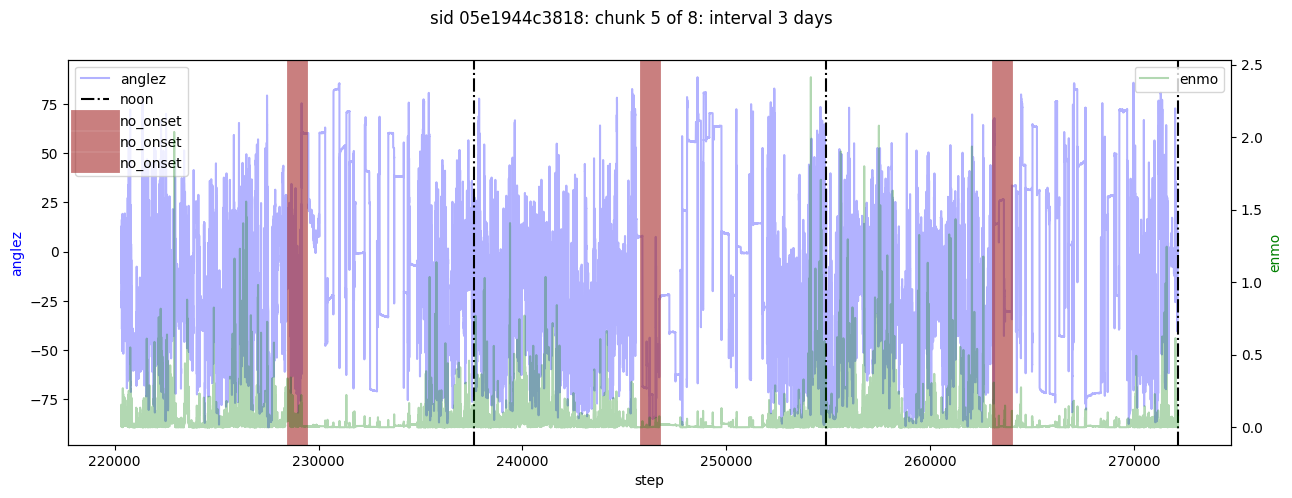

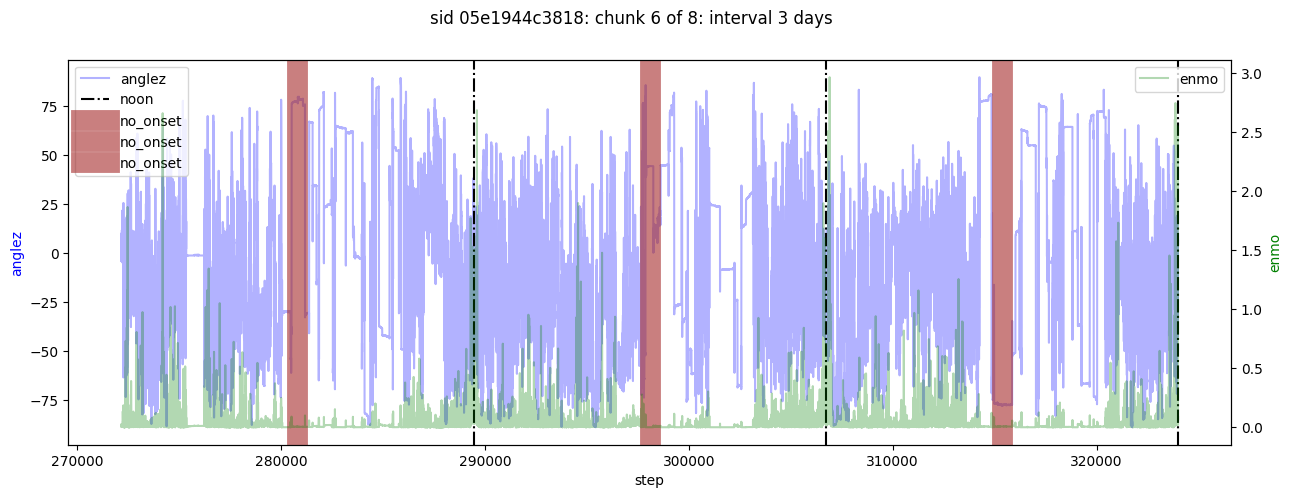

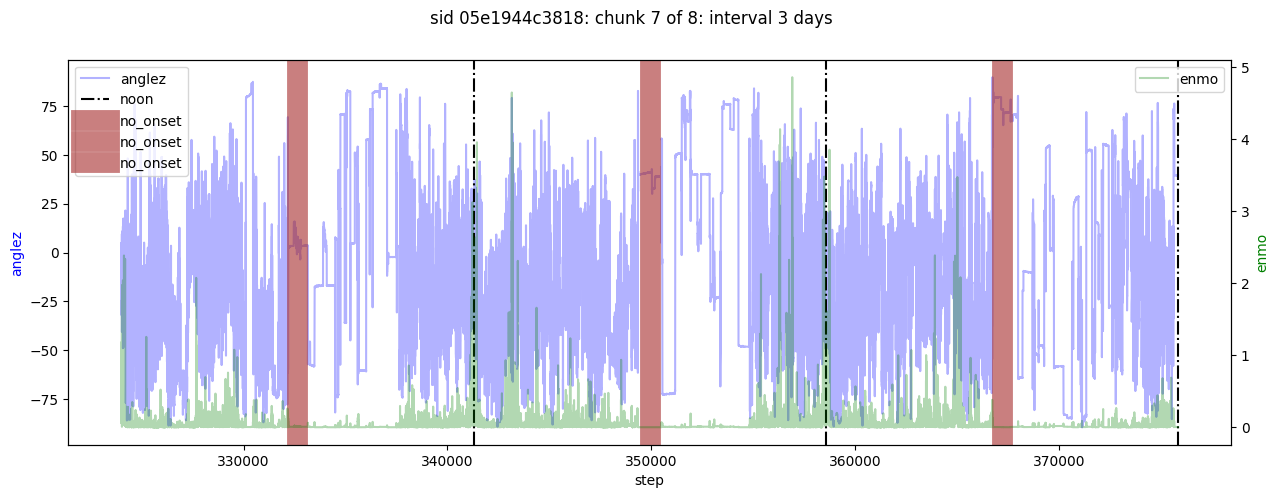

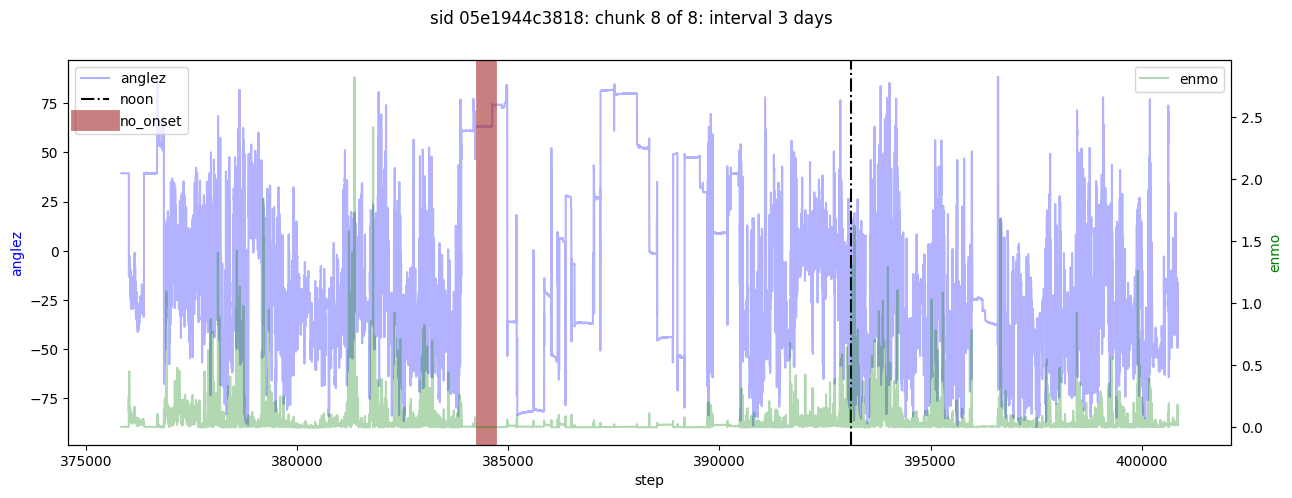

In [31]:
plot_sid(sids[4])

In [32]:
#| hide 
#
# for sid in sids: 
#     plot_sid(sid)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()